In [29]:
import numpy as np
import json
import warnings

import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout, Input, Concatenate, GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
#from tensorflow.keras.callbacks import ReduceLROnPlateau
import json
from evaluator import *

In [30]:
VARIABLES = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

In [31]:
GRAYSCALE = False # grayscale or rgb # TODO: currently not working (MobileNetV2 does not support grayscale)
TRANSFORMER_IMPUTATION = True # whether to use transformer imputation or linear interpolation
FULL_TRANSFORMER_IMPUTATION = False # whether to use FULL transformer imputation or linear interpolation
BACKGROUND_FEATURES = False

# Import data

In [33]:
# file path to data folder
path = './Output' if not TRANSFORMER_IMPUTATION else './Output/transformer_imputation'
path = './Output/full_transformer_imputation' if FULL_TRANSFORMER_IMPUTATION else path
path

'./Output/transformer_imputation'

In [34]:
# dimensions
N, HEIGHT, WIDTH, CHANNELS = sum([1 for p in os.listdir(path) if (p[:14] == 'feature_vector' and p[:19] != 'feature_vector_stat')]), \
                             *np.load(path + '/feature_vector0.npy').shape
CHANNELS = len(VARIABLES) if GRAYSCALE else CHANNELS # reduce channels for grayscale

print(N, HEIGHT, WIDTH, CHANNELS)

613 370 497 30


Metadata (subjectID etc.)

In [35]:
with open(path + '/metadata.txt') as f:
    metadata = f.read()

metadata = json.loads(metadata.replace('\'', '\"').replace('False', 'false').replace('True', 'true')) # doesn't accept other chars

In [36]:
subjects = [meta['subjectID'] for meta in metadata]

In [37]:
# age: 26-35: [0, 0], 36-45: [0, 1], 46-55: [1, 0] (subject 22: unknown -> randomly assigned)
age_ranges = [np.array([0, 0]), np.array([0, 1]), np.array([1, 0])]
age = {1: age_ranges[1],
       2: age_ranges[1],
       3: age_ranges[1],
       4: age_ranges[1],
       5: age_ranges[1],
       6: age_ranges[2],
       7: age_ranges[1],
       8: age_ranges[2],
       9: age_ranges[1],
       10: age_ranges[1],
       11: age_ranges[1],
       12: age_ranges[2],
       13: age_ranges[2],
       14: age_ranges[1],
       15: age_ranges[2],
       16: age_ranges[0],
       17: age_ranges[2],
       18: age_ranges[2],
       19: age_ranges[1],
       20: age_ranges[2],
       21: age_ranges[2],
       22: age_ranges[np.random.choice((0, 1, 2))],
       23: age_ranges[0],
       24: age_ranges[0],
       25: age_ranges[2],
       26: age_ranges[0],
       27: age_ranges[1],
       28: age_ranges[0]}
age = [age[subject] for subject in subjects]

In [38]:
# gender: 0: male, 1: female (subject 22: unknown -> randomly assigned)
gender = {1: 0,
          2: 0,
          3: 0,
          4: 1,
          5: 1,
          6: 1,
          7: 0,
          8: 0,
          9: 0,
          10: 1,
          11: 1,
          12: 1,
          13: 0,
          14: 1,
          15: 1,
          16: 1,
          17: 0,
          18: 0,
          19: 0,
          20: 0,
          21: 0,
          22: np.random.choice((0, 1)),
          23: 1,
          24: 0,
          25: 0,
          26: 0,
          27: 1,
          28: 0}
gender = [gender[subject] for subject in subjects]

# CNN

Addditional functions

In [39]:
# image-wise transformer
def rgb2gray(rgb):
    """greyscale = 0.2989 * red + 0.5870 * green + 0.1140 * blue"""
    return np.dot(rgb[:, :, :3], [0.2989, 0.5870, 0.1140])

# loss function
def weighted_cross_entropy(weight):
    def weighted_cross_entropy_with_logits(labels, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels, logits, weight
        )
        return loss
    return weighted_cross_entropy_with_logits

# weight (imbalanced classes)
def check_imbalance(path_to_labels, indices, variable):
    """Returns indices of positives/negatives"""
    y = np.empty((len(indices), 2), dtype=int)
    for i, index in enumerate(indices):
        y[i, ] = np.load(path_to_labels + f'/labels{index}.npy', allow_pickle=True)

    positives = np.where(y[:, variable] == 1)[0]
    negatives = np.where(y[:, variable] == 0)[0]

    return np.array(indices)[positives], np.array(indices)[negatives]

def get_weighting_factor(path, train_set_indices, variable):
    positives, negatives = check_imbalance(path, train_set_indices, variable)
    sample_weight = len(negatives) / len(positives) # for weighted cross-entropy
    return sample_weight

Dataloader (dataset with images too large)

In [40]:
class DataGenerator(Sequence):

    def __init__(self, data_path: str, indices_dataset: list, variable, batch_size=32, dim=(HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):
        self.data_path = data_path # path to full dataset
        self.dim = dim # image dimension
        self.batch_size = batch_size
        self.indices_dataset = indices_dataset # indices of full dataset (different for train/validation/test set)
        self.n_channels = n_channels
        self.shuffle = shuffle
        assert variable in (0, 1)
        self.variable = variable

        self.on_epoch_end() # shuffle data for each epoch

    def on_epoch_end(self):
        """
        Shuffle data for each epoch
        """
        if self.shuffle:
            np.random.shuffle(self.indices_dataset)

    def __data_generation(self, indices):
        """
        Loads and returns datapoints[indices]
        """
        # init
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty(self.batch_size, dtype=float) # float: logits, int: non-logits

        # load individual datapoints
        for i, index in enumerate(indices):
            images = np.load(self.data_path + f'/feature_vector{index}.npy', allow_pickle=True)
            if GRAYSCALE:
                images_gray = np.empty((HEIGHT, WIDTH, self.n_channels))
                for j in range(len(VARIABLES)):
                    image_rgb = images[:, :, (3 * j): (3 * (j + 1))]
                    image_gray = rgb2gray(image_rgb)
                    images_gray[:, :, j] = image_gray
                images = images_gray

            X[i, ] = images
            y[i] = np.load(self.data_path + f'/labels{index}.npy', allow_pickle=True)[self.variable]

        if BACKGROUND_FEATURES:
            global age, gender
            background_features = np.empty((self.batch_size, *self.dim, 3)) # create pseudo-image to comply with network
            for i, index in enumerate(indices):
                age_i, gender_i = age[i], gender[i]
                background_features[i, ] = np.dstack([np.ones(self.dim) * age_i[0],
                                                     np.ones(self.dim) * age_i[1],
                                                     np.ones(self.dim) * gender_i])

            X = np.concatenate([X, background_features], axis=-1)

        return X, y

    def __len__(self):
        """
        Number of batches per epoch
        """
        return int(np.floor(len(self.indices_dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates batch[index]
        """
        # calculate indices of batch
        indices = self.indices_dataset[index * self.batch_size:(index + 1) * self.batch_size]

        # generate batch
        X, y = self.__data_generation(indices)

        return X, y

Architecture

In [41]:
class ConvNet_larger(tf.keras.Model):

    def __init__(self, name='cnn', **kwargs):
        super(ConvNet_larger, self).__init__(name, **kwargs)

        self.in_shape = (HEIGHT, WIDTH, CHANNELS) if not BACKGROUND_FEATURES else (HEIGHT, WIDTH, CHANNELS + 3)
        self.in_shape_mobilenet = (HEIGHT, WIDTH, 3) if not GRAYSCALE else (HEIGHT, WIDTH, 1)

        # MobileNetV2 embedding
        self.mobilenet = MobileNetV2(input_shape=self.in_shape_mobilenet, weights='imagenet', include_top=False)
        self.mobilenet._name = 'mobilenet'
        self.mobilenet.trainable = False
        self.finetuning = False
        self.out_shape_mobilenet = self.mobilenet.layers[-1].output_shape # for one spectrogram

        # Concatenation
        self.concat = Concatenate(name='concat')

        # Global pooling
        '''self.pool = GlobalAvgPool2D(name='global_avg_pool')'''

        # TODO: more sophisticated dense (dropout, regularizer, init., ...)
        self.conv0 = Conv2D(filters=4, kernel_size=(1, 1), activation='relu', padding='same', name='conv0')
        self.conv1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', name='conv1')
        self.batch_norm1 = BatchNormalization(name='batch_norm1') # try for incr. stability
        self.pool1 = MaxPool2D(strides=(2, 2), name='pool1')

        self.conv2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv2')
        self.batch_norm2 = BatchNormalization(name='batch_norm2') # try for incr. stability
        self.pool2 = MaxPool2D(strides=(2, 2), name='pool2')

        self.flatten = Flatten(name='flatten')

        self.dense = Dense(10, name='dense')

        # Fully-connected network
        if BACKGROUND_FEATURES:
            self.concat2 = Concatenate(name='concat2', axis=-1)
        self.dense2 = Dense(1, name='dense2') # keep logits
        self.out_shape = 1

        # build graph
        self.build_graph()

    def build_graph(self):
        self.build(input_shape=(None, *self.in_shape))
        x = Input(shape=self.in_shape)
        Model(inputs=[x], outputs=self.call(x))

    def set_finetuning(self, mode=True):
        self.finetuning = mode
        self.mobilenet.trainable = mode

        for layers in self.mobilenet.layers:
            layers.trainable = False

        # "activate" last conv layer of MobileNet
        self.mobilenet.layers[-3].trainable = mode
        self.mobilenet.layers[-2].trainable = mode

    def call(self, inputs, background_features=None):
        """
        Model predictions (logits)
        :param background_features: additional features of shape (3)
        :param inputs: all spectrograms of shape (HEIGHT, WIDTH, CHANNELS)
        :return: class prediction (logits)
        """
        if BACKGROUND_FEATURES:
            inputs = inputs[:, :, :, :-3]
            background_features = inputs[:, 0, 0, -3:]

        # MobileNetV2 embeddings
        x = [self.mobilenet(inputs[..., i:i+3], training=self.finetuning) for i in range(0, CHANNELS, 3)]

        # Concatenation
        x = self.concat(x)

        # Global pooling
        '''x = self.pool(x)'''
        x= self.conv0(x)
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        x = self.flatten(x)

        if background_features is not None:
            x = self.concat2([x, background_features])

        # Fully-connected network
        x = self.dense(x)
        x = self.dense2(x)

        return x

In [42]:
class ConvNet(tf.keras.Model):

    def __init__(self, name='cnn', **kwargs):
        super(ConvNet, self).__init__(name, **kwargs)

        self.in_shape = (HEIGHT, WIDTH, CHANNELS) if not BACKGROUND_FEATURES else (HEIGHT, WIDTH, CHANNELS + 3)
        self.in_shape_mobilenet = (HEIGHT, WIDTH, 3) if not GRAYSCALE else (HEIGHT, WIDTH, 1)

        # MobileNetV2 embedding
        self.mobilenet = MobileNetV2(input_shape=self.in_shape_mobilenet, weights='imagenet', include_top=False)
        self.mobilenet._name = 'mobilenet'
        self.mobilenet.trainable = False
        self.finetuning = False
        self.out_shape_mobilenet = self.mobilenet.layers[-1].output_shape # for one spectrogram

        # Concatenation
        self.concat = Concatenate(name='concat')

        # Global pooling
        self.pool = GlobalAvgPool2D(name='global_avg_pool')

        # TODO: more sophisticated dense (dropout, regularizer, init., ...)
        # Fully-connected network
        if BACKGROUND_FEATURES:
            self.concat2 = Concatenate(name='concat2', axis=-1)
        self.dense = Dense(1, name='dense') # keep logits
        self.out_shape = 1

        # build graph
        self.build_graph()

    def build_graph(self):
        self.build(input_shape=(None, *self.in_shape))
        x = Input(shape=self.in_shape)
        Model(inputs=[x], outputs=self.call(x))

    def set_finetuning(self, mode=True):
        self.finetuning = mode
        self.mobilenet.trainable = mode

        for layers in self.mobilenet.layers:
            layers.trainable = False

        # "activate" last conv layer of MobileNet
        self.mobilenet.layers[-3].trainable = mode
        self.mobilenet.layers[-2].trainable = mode

    def call(self, inputs, background_features=None):
        """
        Model predictions (logits)
        :param background_features: additional features of shape (3)
        :param inputs: all spectrograms of shape (HEIGHT, WIDTH, CHANNELS)
        :return: class prediction (logits)
        """
        if BACKGROUND_FEATURES:
            inputs = inputs[:, :, :, :-3]
            background_features = inputs[:, 0, 0, -3:]

        # MobileNetV2 embeddings
        x = [self.mobilenet(inputs[..., i:i+3], training=self.finetuning) for i in range(0, CHANNELS, 3)]

        # Concatenation
        x = self.concat(x)

        # Global pooling
        x = self.pool(x)

        if background_features is not None:
            x = self.concat2([x, background_features])

        # Fully-connected network
        x = self.dense(x)

        return x

Model

In [43]:
class CNN:

    def __init__(self, path, variable, epochs, learning_rate, batch_size):
        self.model = ConvNet()
        self.path = path
        assert variable in (0, 1)
        self.variable = variable
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.history = None
        self.train_indices = None
        self.test_indices = None

    def fit(self, train_indices, validation_indices=None):
        self.train_indices = train_indices

        # training set
        train_dataloader = DataGenerator(self.path, train_indices, batch_size=self.batch_size, variable=self.variable)

        # validation set
        if validation_indices is not None:
            val_dataloader = DataGenerator(self.path, validation_indices, batch_size=self.batch_size, variable=self.variable)

        # weights for loss function
        sample_weights = get_weighting_factor(self.path, train_indices, self.variable)

        # build model
        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                           loss=weighted_cross_entropy(sample_weights))

        # training
        if validation_indices is not None:
            self.history = self.model.fit_generator(generator=train_dataloader,
                                                    validation_data=val_dataloader,
                                                    epochs=self.epochs).history
        else:
            self.history = self.model.fit_generator(generator=train_dataloader,
                                                    epochs=self.epochs).history

    def reset(self):
        """Resets model weights"""
        self.model = ConvNet()

    def predict(self, test_indices, logits=False):
        """Predicts actual class labels by default (not logits/probability values)"""
        self.test_indices = test_indices

        # TODO: make more efficient
        # test set + predict
        y_pred = np.empty(len(test_indices), dtype=float)

        for i, index in enumerate(test_indices):
            X_i = np.load(path + f'/feature_vector{index}.npy', allow_pickle=True)
            X_i = tf.expand_dims(X_i, axis=0) # add "batch dimension"

            if BACKGROUND_FEATURES:
                global age, gender
                age_i, gender_i = age[index], gender[index]
                background_features = np.dstack([np.ones((X_i.shape[1], X_i.shape[2])) * age_i[0],
                                                 np.ones((X_i.shape[1], X_i.shape[2])) * age_i[1],
                                                 np.ones((X_i.shape[1], X_i.shape[2])) * gender_i])
                background_features = tf.expand_dims(background_features, axis=0) # add "batch dimension"

                X_i = np.concatenate([X_i, background_features], axis=-1)

            logits_pred_i = self.model.predict(X_i)

            y_pred[i] = logits_pred_i

        if logits:
            return y_pred

        y_probs = tf.math.sigmoid(y_pred) # logits to probs
        y_pred = tf.round(y_probs) # probs to labels

        return y_pred

    def summary(self):
        return self.model.summary()

In [44]:
CNN(path, variable=0, epochs=10, learning_rate=1e-3, batch_size=16).summary()

Model: "conv_net_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet (Functional)       (None, 12, 16, 1280)      2257984   
_________________________________________________________________
concat (Concatenate)         (None, 12, 16, 12800)     0         
_________________________________________________________________
global_avg_pool (GlobalAvera (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 12801     
Total params: 2,270,785
Trainable params: 12,801
Non-trainable params: 2,257,984
_________________________________________________________________


# CV

In [45]:
%%time
scores_strat_group_k_fold = [None]*2
scores_loso = [None]*2
scores_strat_k_fold = [None]*2

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    for variable in (0, 1): # phF, MF
        model = CNN(path, variable=variable, epochs=10, learning_rate=1e-3, batch_size=16)

        scores_strat_group_k_fold[variable] = stratified_group_k_fold(path=path,
                                                            groups=subjects,
                                                            model=model,
                                                            folds=5,
                                                            images=True,
                                                            verbose=True,
                                                            variable=variable)

        scores_loso[variable] = leave_one_subject_out(path=path,
                                            groups=subjects,
                                            model=model,
                                            images=True,
                                            verbose=True,
                                            variable=variable)

        scores_strat_k_fold[variable] = stratified_k_fold(path=path,
                                                          model=model,
                                                          folds=5,
                                                          images=True,
                                                          verbose=True,
                                                          variable=variable)

Starting stratified group 5-fold for physical fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
36/36 [==============================] - 73s 1s/step - loss: 0.5009
Epoch 2/10
36/36 [==============================] - 24s 644ms/step - loss: 0.3349
Epoch 3/10
36/36 [==============================] - 24s 643ms/step - loss: 0.3002
Epoch 4/10
36/36 [==============================] - 24s 644ms/step - loss: 0.2833
Epoch 5/10
36/36 [==============================] - 24s 643ms/step - loss: 0.2754
Epoch 6/10
36/36 [==============================] - 24s 643ms/step - loss: 0.2541
Epoch 7/10
36/36 [==============================] - 24s 670ms/step - loss: 0.2329
Epoch 8/10
36/36 [==============================] - 23s 640ms/step - loss: 0.2273
Epoch 9/10
36/36 [==============================] - 23s 641ms/step - loss: 0.2093
Epoch 10/10
36/36 [==============================] - 23s 640ms/step - loss: 0.2111


 Fold 1 F1: 0.8148148148148148:  20%|██        | 1/5 [05:09<20:39, 309.95s/it]

Epoch 1/10
24/24 [==============================] - 40s 640ms/step - loss: 0.5588
Epoch 2/10
24/24 [==============================] - 16s 638ms/step - loss: 0.4697
Epoch 3/10
24/24 [==============================] - 16s 638ms/step - loss: 0.3709
Epoch 4/10
24/24 [==============================] - 16s 639ms/step - loss: 0.2781
Epoch 5/10
24/24 [==============================] - 16s 639ms/step - loss: 0.2627
Epoch 6/10
24/24 [==============================] - 16s 638ms/step - loss: 0.2699
Epoch 7/10
24/24 [==============================] - 16s 639ms/step - loss: 0.2347
Epoch 8/10
24/24 [==============================] - 16s 641ms/step - loss: 0.2252
Epoch 9/10
24/24 [==============================] - 16s 642ms/step - loss: 0.2164
Epoch 10/10
24/24 [==============================] - 16s 640ms/step - loss: 0.2311


 Fold 2 F1: 0.6212211466865226:  40%|████      | 2/5 [09:01<13:11, 263.74s/it]

Epoch 1/10
30/30 [==============================] - 44s 635ms/step - loss: 0.3576
Epoch 2/10
30/30 [==============================] - 19s 636ms/step - loss: 0.2695
Epoch 3/10
30/30 [==============================] - 19s 636ms/step - loss: 0.2517
Epoch 4/10
30/30 [==============================] - 19s 636ms/step - loss: 0.2666
Epoch 5/10
30/30 [==============================] - 19s 636ms/step - loss: 0.2242
Epoch 6/10
30/30 [==============================] - 19s 636ms/step - loss: 0.2122
Epoch 7/10
30/30 [==============================] - 19s 636ms/step - loss: 0.1915
Epoch 8/10
30/30 [==============================] - 19s 636ms/step - loss: 0.1892
Epoch 9/10
30/30 [==============================] - 19s 637ms/step - loss: 0.1645
Epoch 10/10
30/30 [==============================] - 19s 636ms/step - loss: 0.1551


 Fold 3 F1: 0.5638822860686236:  60%|██████    | 3/5 [13:14<08:38, 259.00s/it]

Epoch 1/10
25/25 [==============================] - 39s 647ms/step - loss: 0.6345
Epoch 2/10
25/25 [==============================] - 17s 648ms/step - loss: 0.4443
Epoch 3/10
25/25 [==============================] - 17s 648ms/step - loss: 0.3817
Epoch 4/10
25/25 [==============================] - 17s 647ms/step - loss: 0.3440
Epoch 5/10
25/25 [==============================] - 17s 647ms/step - loss: 0.3199
Epoch 6/10
25/25 [==============================] - 17s 646ms/step - loss: 0.3383
Epoch 7/10
25/25 [==============================] - 17s 646ms/step - loss: 0.3071
Epoch 8/10
25/25 [==============================] - 17s 646ms/step - loss: 0.2843
Epoch 9/10
25/25 [==============================] - 17s 647ms/step - loss: 0.2926
Epoch 10/10
25/25 [==============================] - 17s 647ms/step - loss: 0.2495


 Fold 4 F1: 0.525308660078008:  80%|████████  | 4/5 [17:10<04:09, 249.95s/it] 

Epoch 1/10
36/36 [==============================] - 47s 636ms/step - loss: 0.4424
Epoch 2/10
36/36 [==============================] - 23s 638ms/step - loss: 0.3028
Epoch 3/10
36/36 [==============================] - 23s 632ms/step - loss: 0.3172
Epoch 4/10
36/36 [==============================] - 23s 619ms/step - loss: 0.2588
Epoch 5/10
36/36 [==============================] - 23s 621ms/step - loss: 0.2488
Epoch 6/10
36/36 [==============================] - 23s 620ms/step - loss: 0.2381
Epoch 7/10
36/36 [==============================] - 23s 622ms/step - loss: 0.2182
Epoch 8/10
36/36 [==============================] - 23s 620ms/step - loss: 0.2178
Epoch 9/10
36/36 [==============================] - 23s 620ms/step - loss: 0.2436
Epoch 10/10
36/36 [==============================] - 23s 622ms/step - loss: 0.1996


 Fold 5 F1: 0.5232076044089392: 100%|██████████| 5/5 [21:40<00:00, 260.20s/it]


Performance model:
 accuracy: 0.593 +- 0.114 

 balanced_accuracy: 0.585 +- 0.034 

 f1: 0.61 +- 0.109 

 recall: 0.593 +- 0.114 

 precision: 0.702 +- 0.105 

Starting leave-one-subject-out for physical fatigue


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/10
37/37 [==============================] - 46s 625ms/step - loss: 0.5018
Epoch 2/10
37/37 [==============================] - 24s 626ms/step - loss: 0.3580
Epoch 3/10
37/37 [==============================] - 24s 626ms/step - loss: 0.3528
Epoch 4/10
37/37 [==============================] - 24s 626ms/step - loss: 0.2921
Epoch 5/10
37/37 [==============================] - 23s 625ms/step - loss: 0.2792
Epoch 6/10
37/37 [==============================] - 24s 626ms/step - loss: 0.2509
Epoch 7/10
37/37 [==============================] - 24s 626ms/step - loss: 0.2523
Epoch 8/10
37/37 [==============================] - 24s 626ms/step - loss: 0.2158
Epoch 9/10
37/37 [==============================] - 24s 626ms/step - loss: 0.2228
Epoch 10/10
37/37 [==============================] - 24s 626ms/step - loss: 0.2151


 Fold 1 F1: 0.8888888888888888:   4%|▎         | 1/27 [04:34<1:58:44, 274.00s/it]

Epoch 1/10
38/38 [==============================] - 47s 626ms/step - loss: 0.4788
Epoch 2/10
38/38 [==============================] - 24s 626ms/step - loss: 0.3417
Epoch 3/10
38/38 [==============================] - 24s 625ms/step - loss: 0.3166
Epoch 4/10
38/38 [==============================] - 24s 624ms/step - loss: 0.2969
Epoch 5/10
38/38 [==============================] - 24s 626ms/step - loss: 0.2668
Epoch 6/10
38/38 [==============================] - 24s 624ms/step - loss: 0.2619
Epoch 7/10
38/38 [==============================] - 24s 625ms/step - loss: 0.2861
Epoch 8/10
38/38 [==============================] - 24s 625ms/step - loss: 0.2347
Epoch 9/10
38/38 [==============================] - 24s 624ms/step - loss: 0.2188
Epoch 10/10
38/38 [==============================] - 24s 626ms/step - loss: 0.1928


 Fold 2 F1: 0.0:   7%|▋         | 2/27 [09:14<1:55:44, 277.77s/it]               

Epoch 1/10
37/37 [==============================] - 47s 653ms/step - loss: 0.5195
Epoch 2/10
37/37 [==============================] - 30s 795ms/step - loss: 0.3519
Epoch 3/10
37/37 [==============================] - 25s 659ms/step - loss: 0.3043
Epoch 4/10
37/37 [==============================] - 25s 653ms/step - loss: 0.2850
Epoch 5/10
37/37 [==============================] - 24s 646ms/step - loss: 0.2436
Epoch 6/10
37/37 [==============================] - 24s 651ms/step - loss: 0.2653
Epoch 7/10
37/37 [==============================] - 24s 640ms/step - loss: 0.2275
Epoch 8/10
37/37 [==============================] - 24s 639ms/step - loss: 0.2463
Epoch 9/10
37/37 [==============================] - 24s 641ms/step - loss: 0.2286
Epoch 10/10
37/37 [==============================] - 24s 641ms/step - loss: 0.2050


 Fold 3 F1: 0.36199095022624433:  11%|█         | 3/27 [14:00<1:52:42, 281.78s/it]

Epoch 1/10
37/37 [==============================] - 48s 642ms/step - loss: 0.4778
Epoch 2/10
37/37 [==============================] - 24s 640ms/step - loss: 0.3208
Epoch 3/10
37/37 [==============================] - 24s 642ms/step - loss: 0.2966
Epoch 4/10
37/37 [==============================] - 24s 642ms/step - loss: 0.2736
Epoch 5/10
37/37 [==============================] - 24s 641ms/step - loss: 0.2784
Epoch 6/10
37/37 [==============================] - 24s 640ms/step - loss: 0.2463
Epoch 7/10
37/37 [==============================] - 24s 636ms/step - loss: 0.2179
Epoch 8/10
37/37 [==============================] - 24s 639ms/step - loss: 0.2195
Epoch 9/10
37/37 [==============================] - 24s 640ms/step - loss: 0.2120
Epoch 10/10
37/37 [==============================] - 24s 637ms/step - loss: 0.1971


 Fold 4 F1: 0.6666666666666666:  15%|█▍        | 4/27 [18:41<1:47:46, 281.13s/it] 

Epoch 1/10
37/37 [==============================] - 49s 640ms/step - loss: 0.5330
Epoch 2/10
37/37 [==============================] - 24s 640ms/step - loss: 0.3344
Epoch 3/10
37/37 [==============================] - 24s 640ms/step - loss: 0.3083
Epoch 4/10
37/37 [==============================] - 24s 640ms/step - loss: 0.3111
Epoch 5/10
37/37 [==============================] - 24s 641ms/step - loss: 0.2707
Epoch 6/10
37/37 [==============================] - 24s 642ms/step - loss: 0.2787
Epoch 7/10
37/37 [==============================] - 24s 644ms/step - loss: 0.2610
Epoch 8/10
37/37 [==============================] - 24s 624ms/step - loss: 0.2536
Epoch 9/10
37/37 [==============================] - 23s 625ms/step - loss: 0.2201
Epoch 10/10
37/37 [==============================] - 23s 624ms/step - loss: 0.1996


 Fold 5 F1: 0.2857142857142857:  19%|█▊        | 5/27 [23:19<1:42:40, 280.02s/it]

Epoch 1/10
37/37 [==============================] - 47s 625ms/step - loss: 0.5106
Epoch 2/10
37/37 [==============================] - 24s 625ms/step - loss: 0.3608
Epoch 3/10
37/37 [==============================] - 23s 625ms/step - loss: 0.3691
Epoch 4/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3000
Epoch 5/10
37/37 [==============================] - 23s 625ms/step - loss: 0.3054
Epoch 6/10
37/37 [==============================] - 24s 625ms/step - loss: 0.2595
Epoch 7/10
37/37 [==============================] - 24s 626ms/step - loss: 0.3000
Epoch 8/10
37/37 [==============================] - 23s 625ms/step - loss: 0.2297
Epoch 9/10
37/37 [==============================] - 23s 624ms/step - loss: 0.2230
Epoch 10/10
37/37 [==============================] - 23s 625ms/step - loss: 0.2315


 Fold 6 F1: 0.7575757575757575:  22%|██▏       | 6/27 [27:51<1:37:07, 277.52s/it]

Epoch 1/10
38/38 [==============================] - 49s 634ms/step - loss: 0.4012
Epoch 2/10
38/38 [==============================] - 24s 634ms/step - loss: 0.3272
Epoch 3/10
38/38 [==============================] - 25s 636ms/step - loss: 0.3552
Epoch 4/10
38/38 [==============================] - 24s 635ms/step - loss: 0.2662
Epoch 5/10
38/38 [==============================] - 25s 636ms/step - loss: 0.3108
Epoch 6/10
38/38 [==============================] - 25s 635ms/step - loss: 0.2830
Epoch 7/10
38/38 [==============================] - 25s 635ms/step - loss: 0.2828
Epoch 8/10
38/38 [==============================] - 25s 635ms/step - loss: 0.2288
Epoch 9/10
38/38 [==============================] - 24s 635ms/step - loss: 0.2450
Epoch 10/10
38/38 [==============================] - 24s 635ms/step - loss: 0.1940


 Fold 7 F1: 0.5333333333333333:  26%|██▌       | 7/27 [32:34<1:33:04, 279.22s/it]

Epoch 1/10
37/37 [==============================] - 47s 627ms/step - loss: 0.4858
Epoch 2/10
37/37 [==============================] - 24s 628ms/step - loss: 0.3625
Epoch 3/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3308
Epoch 4/10
37/37 [==============================] - 24s 630ms/step - loss: 0.2847
Epoch 5/10
37/37 [==============================] - 24s 628ms/step - loss: 0.2608
Epoch 6/10
37/37 [==============================] - 24s 630ms/step - loss: 0.2635
Epoch 7/10
37/37 [==============================] - 24s 630ms/step - loss: 0.2218
Epoch 8/10
37/37 [==============================] - 24s 629ms/step - loss: 0.2332
Epoch 9/10
37/37 [==============================] - 24s 632ms/step - loss: 0.2199
Epoch 10/10
37/37 [==============================] - 24s 631ms/step - loss: 0.2579


 Fold 8 F1: 0.03571428571428571:  30%|██▉       | 8/27 [37:09<1:28:01, 277.98s/it]

Epoch 1/10
37/37 [==============================] - 48s 622ms/step - loss: 0.4266
Epoch 2/10
37/37 [==============================] - 23s 621ms/step - loss: 0.3892
Epoch 3/10
37/37 [==============================] - 23s 622ms/step - loss: 0.2775
Epoch 4/10
37/37 [==============================] - 23s 621ms/step - loss: 0.2656
Epoch 5/10
37/37 [==============================] - 23s 622ms/step - loss: 0.2493
Epoch 6/10
37/37 [==============================] - 23s 622ms/step - loss: 0.2626
Epoch 7/10
37/37 [==============================] - 23s 621ms/step - loss: 0.2419
Epoch 8/10
37/37 [==============================] - 23s 619ms/step - loss: 0.2624
Epoch 9/10
37/37 [==============================] - 23s 620ms/step - loss: 0.2381
Epoch 10/10
37/37 [==============================] - 23s 622ms/step - loss: 0.1997


 Fold 9 F1: 0.7499999999999999:  33%|███▎      | 9/27 [41:42<1:22:52, 276.24s/it] 

Epoch 1/10
37/37 [==============================] - 47s 623ms/step - loss: 0.4508
Epoch 2/10
37/37 [==============================] - 23s 622ms/step - loss: 0.3354
Epoch 3/10
37/37 [==============================] - 23s 620ms/step - loss: 0.3241
Epoch 4/10
37/37 [==============================] - 23s 621ms/step - loss: 0.2990
Epoch 5/10
37/37 [==============================] - 23s 622ms/step - loss: 0.2655
Epoch 6/10
37/37 [==============================] - 23s 623ms/step - loss: 0.2766
Epoch 7/10
37/37 [==============================] - 23s 622ms/step - loss: 0.2290
Epoch 8/10
37/37 [==============================] - 30s 800ms/step - loss: 0.2168
Epoch 9/10
37/37 [==============================] - 24s 638ms/step - loss: 0.2078
Epoch 10/10
37/37 [==============================] - 24s 637ms/step - loss: 0.2058


 Fold 10 F1: 0.06666666666666668:  37%|███▋      | 10/27 [46:22<1:18:35, 277.38s/it]

Epoch 1/10
37/37 [==============================] - 49s 646ms/step - loss: 0.5341
Epoch 2/10
37/37 [==============================] - 24s 651ms/step - loss: 0.4487
Epoch 3/10
37/37 [==============================] - 24s 647ms/step - loss: 0.3094
Epoch 4/10
37/37 [==============================] - 24s 646ms/step - loss: 0.2709
Epoch 5/10
37/37 [==============================] - 24s 645ms/step - loss: 0.2724
Epoch 6/10
37/37 [==============================] - 24s 644ms/step - loss: 0.2416
Epoch 7/10
37/37 [==============================] - 24s 643ms/step - loss: 0.2321
Epoch 8/10
37/37 [==============================] - 24s 645ms/step - loss: 0.2250
Epoch 9/10
37/37 [==============================] - 24s 645ms/step - loss: 0.2167
Epoch 10/10
37/37 [==============================] - 24s 645ms/step - loss: 0.2040


 Fold 11 F1: 0.5142857142857142:  41%|████      | 11/27 [51:04<1:14:23, 278.97s/it] 

Epoch 1/10
37/37 [==============================] - 48s 638ms/step - loss: 0.4039
Epoch 2/10
37/37 [==============================] - 24s 637ms/step - loss: 0.3163
Epoch 3/10
37/37 [==============================] - 24s 636ms/step - loss: 0.2935
Epoch 4/10
37/37 [==============================] - 24s 639ms/step - loss: 0.3141
Epoch 5/10
37/37 [==============================] - 24s 638ms/step - loss: 0.2620
Epoch 6/10
37/37 [==============================] - 24s 637ms/step - loss: 0.2928
Epoch 7/10
37/37 [==============================] - 24s 647ms/step - loss: 0.2190
Epoch 8/10
37/37 [==============================] - 24s 637ms/step - loss: 0.2050
Epoch 9/10
37/37 [==============================] - 24s 637ms/step - loss: 0.2314
Epoch 10/10
37/37 [==============================] - 24s 630ms/step - loss: 0.1850


 Fold 12 F1: 0.6588235294117648:  44%|████▍     | 12/27 [55:43<1:09:42, 278.83s/it]

Epoch 1/10
37/37 [==============================] - 46s 625ms/step - loss: 0.4924
Epoch 2/10
37/37 [==============================] - 24s 625ms/step - loss: 0.3329
Epoch 3/10
37/37 [==============================] - 24s 626ms/step - loss: 0.2883
Epoch 4/10
37/37 [==============================] - 24s 627ms/step - loss: 0.2673
Epoch 5/10
37/37 [==============================] - 24s 626ms/step - loss: 0.2538
Epoch 6/10
37/37 [==============================] - 24s 627ms/step - loss: 0.2450
Epoch 7/10
37/37 [==============================] - 24s 627ms/step - loss: 0.2353
Epoch 8/10
37/37 [==============================] - 24s 626ms/step - loss: 0.2085
Epoch 9/10
37/37 [==============================] - 24s 626ms/step - loss: 0.2237
Epoch 10/10
37/37 [==============================] - 25s 660ms/step - loss: 0.3135


 Fold 13 F1: 0.2571428571428571:  48%|████▊     | 13/27 [1:00:20<1:04:55, 278.26s/it]

Epoch 1/10
37/37 [==============================] - 54s 716ms/step - loss: 0.4609
Epoch 2/10
37/37 [==============================] - 25s 669ms/step - loss: 0.3338
Epoch 3/10
37/37 [==============================] - 25s 673ms/step - loss: 0.3044
Epoch 4/10
37/37 [==============================] - 25s 659ms/step - loss: 0.2916
Epoch 5/10
37/37 [==============================] - 25s 658ms/step - loss: 0.3223
Epoch 6/10
37/37 [==============================] - 25s 659ms/step - loss: 0.2492
Epoch 7/10
37/37 [==============================] - 25s 666ms/step - loss: 0.2611
Epoch 8/10
37/37 [==============================] - 25s 663ms/step - loss: 0.2346
Epoch 9/10
37/37 [==============================] - 25s 654ms/step - loss: 0.2148
Epoch 10/10
37/37 [==============================] - 25s 664ms/step - loss: 0.2130


 Fold 14 F1: 0.8000000000000002:  52%|█████▏    | 14/27 [1:05:19<1:01:38, 284.49s/it]

Epoch 1/10
37/37 [==============================] - 50s 662ms/step - loss: 0.4549
Epoch 2/10
37/37 [==============================] - 25s 671ms/step - loss: 0.3159
Epoch 3/10
37/37 [==============================] - 26s 698ms/step - loss: 0.3020
Epoch 4/10
37/37 [==============================] - 25s 660ms/step - loss: 0.2866
Epoch 5/10
37/37 [==============================] - 25s 659ms/step - loss: 0.2702
Epoch 6/10
37/37 [==============================] - 25s 656ms/step - loss: 0.2521
Epoch 7/10
37/37 [==============================] - 25s 656ms/step - loss: 0.2421
Epoch 8/10
37/37 [==============================] - 25s 654ms/step - loss: 0.2645
Epoch 9/10
37/37 [==============================] - 24s 650ms/step - loss: 0.2894
Epoch 10/10
37/37 [==============================] - 25s 657ms/step - loss: 0.2291


 Fold 15 F1: 0.3212121212121213:  56%|█████▌    | 15/27 [1:10:11<57:21, 286.81s/it]  

Epoch 1/10
37/37 [==============================] - 50s 646ms/step - loss: 0.4028
Epoch 2/10
37/37 [==============================] - 24s 651ms/step - loss: 0.3309
Epoch 3/10
37/37 [==============================] - 24s 640ms/step - loss: 0.3055
Epoch 4/10
37/37 [==============================] - 25s 661ms/step - loss: 0.2838
Epoch 5/10
37/37 [==============================] - 27s 720ms/step - loss: 0.3255
Epoch 6/10
37/37 [==============================] - 25s 656ms/step - loss: 0.2388
Epoch 7/10
37/37 [==============================] - 24s 646ms/step - loss: 0.2789
Epoch 8/10
37/37 [==============================] - 24s 641ms/step - loss: 0.2927
Epoch 9/10
37/37 [==============================] - 24s 640ms/step - loss: 0.2791
Epoch 10/10
37/37 [==============================] - 24s 642ms/step - loss: 0.2515


 Fold 16 F1: 0.38333333333333336:  59%|█████▉    | 16/27 [1:14:59<52:39, 287.26s/it]

Epoch 1/10
37/37 [==============================] - 48s 641ms/step - loss: 0.5003
Epoch 2/10
37/37 [==============================] - 24s 645ms/step - loss: 0.3195
Epoch 3/10
37/37 [==============================] - 27s 729ms/step - loss: 0.2917
Epoch 4/10
37/37 [==============================] - 28s 750ms/step - loss: 0.2768
Epoch 5/10
37/37 [==============================] - 27s 718ms/step - loss: 0.3057
Epoch 6/10
37/37 [==============================] - 24s 642ms/step - loss: 0.2288
Epoch 7/10
37/37 [==============================] - 24s 639ms/step - loss: 0.2278
Epoch 8/10
37/37 [==============================] - 24s 640ms/step - loss: 0.2226
Epoch 9/10
37/37 [==============================] - 24s 639ms/step - loss: 0.2123
Epoch 10/10
37/37 [==============================] - 24s 638ms/step - loss: 0.1940


 Fold 17 F1: 0.6692307692307692:  63%|██████▎   | 17/27 [1:19:52<48:09, 288.99s/it] 

Epoch 1/10
37/37 [==============================] - 49s 661ms/step - loss: 0.4031
Epoch 2/10
37/37 [==============================] - 25s 652ms/step - loss: 0.3128
Epoch 3/10
37/37 [==============================] - 29s 768ms/step - loss: 0.3360
Epoch 4/10
37/37 [==============================] - 25s 661ms/step - loss: 0.2577
Epoch 5/10
37/37 [==============================] - 25s 662ms/step - loss: 0.2419
Epoch 6/10
37/37 [==============================] - 25s 662ms/step - loss: 0.2796
Epoch 7/10
37/37 [==============================] - 24s 652ms/step - loss: 0.2065
Epoch 8/10
37/37 [==============================] - 24s 648ms/step - loss: 0.2203
Epoch 9/10
37/37 [==============================] - 24s 648ms/step - loss: 0.2220
Epoch 10/10
37/37 [==============================] - 24s 644ms/step - loss: 0.1842


 Fold 18 F1: 0.04102564102564103:  67%|██████▋   | 18/27 [1:24:44<43:29, 289.92s/it]

Epoch 1/10
37/37 [==============================] - 52s 658ms/step - loss: 0.3886
Epoch 2/10
37/37 [==============================] - 24s 647ms/step - loss: 0.3147
Epoch 3/10
37/37 [==============================] - 24s 644ms/step - loss: 0.2914
Epoch 4/10
37/37 [==============================] - 24s 645ms/step - loss: 0.3403
Epoch 5/10
37/37 [==============================] - 27s 722ms/step - loss: 0.2660
Epoch 6/10
37/37 [==============================] - 27s 723ms/step - loss: 0.2272
Epoch 7/10
37/37 [==============================] - 30s 806ms/step - loss: 0.2314
Epoch 8/10
37/37 [==============================] - 30s 795ms/step - loss: 0.2069
Epoch 9/10
37/37 [==============================] - 30s 791ms/step - loss: 0.2249
Epoch 10/10
37/37 [==============================] - 30s 799ms/step - loss: 0.1860


 Fold 19 F1: 0.9:  70%|███████   | 19/27 [1:30:04<39:50, 298.85s/it]                

Epoch 1/10
37/37 [==============================] - 51s 654ms/step - loss: 0.4330
Epoch 2/10
37/37 [==============================] - 24s 651ms/step - loss: 0.3280
Epoch 3/10
37/37 [==============================] - 25s 660ms/step - loss: 0.3169
Epoch 4/10
37/37 [==============================] - 24s 651ms/step - loss: 0.3038
Epoch 5/10
37/37 [==============================] - 24s 650ms/step - loss: 0.2660
Epoch 6/10
37/37 [==============================] - 24s 650ms/step - loss: 0.2771
Epoch 7/10
37/37 [==============================] - 24s 649ms/step - loss: 0.2342
Epoch 8/10
37/37 [==============================] - 24s 651ms/step - loss: 0.2109
Epoch 9/10
37/37 [==============================] - 24s 650ms/step - loss: 0.2127
Epoch 10/10
37/37 [==============================] - 24s 649ms/step - loss: 0.2282


 Fold 20 F1: 1.0:  74%|███████▍  | 20/27 [1:34:56<34:38, 296.87s/it]

Epoch 1/10
37/37 [==============================] - 48s 648ms/step - loss: 0.4265
Epoch 2/10
37/37 [==============================] - 24s 645ms/step - loss: 0.3502
Epoch 3/10
37/37 [==============================] - 24s 649ms/step - loss: 0.3361
Epoch 4/10
37/37 [==============================] - 24s 649ms/step - loss: 0.2837
Epoch 5/10
37/37 [==============================] - 26s 700ms/step - loss: 0.2496
Epoch 6/10
37/37 [==============================] - 26s 678ms/step - loss: 0.2480
Epoch 7/10
37/37 [==============================] - 24s 649ms/step - loss: 0.2490
Epoch 8/10
37/37 [==============================] - 25s 678ms/step - loss: 0.2102
Epoch 9/10
37/37 [==============================] - 24s 641ms/step - loss: 0.2076
Epoch 10/10
37/37 [==============================] - 24s 642ms/step - loss: 0.2013


 Fold 21 F1: 0.5804195804195803:  78%|███████▊  | 21/27 [1:39:44<29:25, 294.27s/it]

Epoch 1/10
37/37 [==============================] - 49s 653ms/step - loss: 0.5011
Epoch 2/10
37/37 [==============================] - 24s 650ms/step - loss: 0.3304
Epoch 3/10
37/37 [==============================] - 24s 649ms/step - loss: 0.3259
Epoch 4/10
37/37 [==============================] - 24s 651ms/step - loss: 0.2911
Epoch 5/10
37/37 [==============================] - 24s 648ms/step - loss: 0.3223
Epoch 6/10
37/37 [==============================] - 24s 648ms/step - loss: 0.3233
Epoch 7/10
37/37 [==============================] - 25s 655ms/step - loss: 0.2273
Epoch 8/10
37/37 [==============================] - 24s 650ms/step - loss: 0.2658
Epoch 9/10
37/37 [==============================] - 25s 677ms/step - loss: 0.2161
Epoch 10/10
37/37 [==============================] - 26s 704ms/step - loss: 0.2450


 Fold 22 F1: 0.6656611362493715:  81%|████████▏ | 22/27 [1:44:36<24:27, 293.59s/it]

Epoch 1/10
31/31 [==============================] - 49s 788ms/step - loss: 0.4973
Epoch 2/10
31/31 [==============================] - 24s 754ms/step - loss: 0.2741
Epoch 3/10
31/31 [==============================] - 23s 742ms/step - loss: 0.2630
Epoch 4/10
31/31 [==============================] - 24s 772ms/step - loss: 0.2350
Epoch 5/10
31/31 [==============================] - 23s 735ms/step - loss: 0.2388
Epoch 6/10
31/31 [==============================] - 22s 705ms/step - loss: 0.2059
Epoch 7/10
31/31 [==============================] - 21s 676ms/step - loss: 0.1806
Epoch 8/10
31/31 [==============================] - 21s 675ms/step - loss: 0.1788
Epoch 9/10
31/31 [==============================] - 21s 674ms/step - loss: 0.1788
Epoch 10/10
31/31 [==============================] - 21s 674ms/step - loss: 0.2098


 Fold 23 F1: 0.5345433199837154:  85%|████████▌ | 23/27 [1:49:26<19:30, 292.50s/it]

Epoch 1/10
29/29 [==============================] - 49s 700ms/step - loss: 0.7928
Epoch 2/10
29/29 [==============================] - 21s 704ms/step - loss: 0.4914
Epoch 3/10
29/29 [==============================] - 20s 684ms/step - loss: 0.3906
Epoch 4/10
29/29 [==============================] - 22s 732ms/step - loss: 0.4032
Epoch 5/10
29/29 [==============================] - 20s 683ms/step - loss: 0.3460
Epoch 6/10
29/29 [==============================] - 20s 680ms/step - loss: 0.3232
Epoch 7/10
29/29 [==============================] - 20s 679ms/step - loss: 0.3323
Epoch 8/10
29/29 [==============================] - 20s 680ms/step - loss: 0.4170
Epoch 9/10
29/29 [==============================] - 20s 689ms/step - loss: 0.3074
Epoch 10/10
29/29 [==============================] - 20s 682ms/step - loss: 0.2958


 Fold 24 F1: 0.9008015368309488:  89%|████████▉ | 24/27 [1:54:03<14:23, 287.70s/it]

Epoch 1/10
36/36 [==============================] - 51s 681ms/step - loss: 0.4570
Epoch 2/10
36/36 [==============================] - 25s 679ms/step - loss: 0.3134
Epoch 3/10
36/36 [==============================] - 25s 680ms/step - loss: 0.2833
Epoch 4/10
36/36 [==============================] - 25s 678ms/step - loss: 0.2821
Epoch 5/10
36/36 [==============================] - 25s 679ms/step - loss: 0.2756
Epoch 6/10
36/36 [==============================] - 25s 680ms/step - loss: 0.3190
Epoch 7/10
36/36 [==============================] - 25s 679ms/step - loss: 0.2612
Epoch 8/10
36/36 [==============================] - 25s 680ms/step - loss: 0.2201
Epoch 9/10
36/36 [==============================] - 25s 680ms/step - loss: 0.2036
Epoch 10/10
36/36 [==============================] - 25s 681ms/step - loss: 0.2136


 Fold 25 F1: 0.5729166666666666:  93%|█████████▎| 25/27 [1:59:01<09:41, 290.82s/it]

Epoch 1/10
34/34 [==============================] - 50s 679ms/step - loss: 0.5597
Epoch 2/10
34/34 [==============================] - 24s 681ms/step - loss: 0.3784
Epoch 3/10
34/34 [==============================] - 24s 680ms/step - loss: 0.3991
Epoch 4/10
34/34 [==============================] - 23s 680ms/step - loss: 0.3449
Epoch 5/10
34/34 [==============================] - 23s 678ms/step - loss: 0.3045
Epoch 6/10
34/34 [==============================] - 23s 675ms/step - loss: 0.3155
Epoch 7/10
34/34 [==============================] - 24s 686ms/step - loss: 0.3784
Epoch 8/10
34/34 [==============================] - 23s 678ms/step - loss: 0.2916
Epoch 9/10
34/34 [==============================] - 23s 678ms/step - loss: 0.3056
Epoch 10/10
34/34 [==============================] - 24s 679ms/step - loss: 0.2400


 Fold 26 F1: 0.8376811594202898:  96%|█████████▋| 26/27 [2:03:51<04:50, 290.51s/it]

Epoch 1/10
35/35 [==============================] - 50s 680ms/step - loss: 0.4380
Epoch 2/10
35/35 [==============================] - 24s 669ms/step - loss: 0.3090
Epoch 3/10
35/35 [==============================] - 24s 670ms/step - loss: 0.3237
Epoch 4/10
35/35 [==============================] - 24s 670ms/step - loss: 0.2707
Epoch 5/10
35/35 [==============================] - 25s 691ms/step - loss: 0.2462
Epoch 6/10
35/35 [==============================] - 24s 671ms/step - loss: 0.2544
Epoch 7/10
35/35 [==============================] - 24s 671ms/step - loss: 0.2986
Epoch 8/10
35/35 [==============================] - 24s 671ms/step - loss: 0.2044
Epoch 9/10
35/35 [==============================] - 24s 670ms/step - loss: 0.1850
Epoch 10/10
35/35 [==============================] - 24s 671ms/step - loss: 0.1837


 Fold 27 F1: 0.3285356695869837: 100%|██████████| 27/27 [2:08:43<00:00, 286.04s/it]


Performance model:
 accuracy: 0.531 +- 0.264 

 balanced_accuracy: 0.548 +- 0.222 

 f1: 0.53 +- 0.287 

 recall: 0.531 +- 0.264 

 precision: 0.656 +- 0.327 

Starting stratified 5-fold for physical fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
30/30 [==============================] - 48s 688ms/step - loss: 0.4419
Epoch 2/10
30/30 [==============================] - 21s 685ms/step - loss: 0.3682
Epoch 3/10
30/30 [==============================] - 21s 702ms/step - loss: 0.2965
Epoch 4/10
30/30 [==============================] - 23s 763ms/step - loss: 0.2821
Epoch 5/10
30/30 [==============================] - 24s 776ms/step - loss: 0.2693
Epoch 6/10
30/30 [==============================] - 24s 778ms/step - loss: 0.2747
Epoch 7/10
30/30 [==============================] - 24s 793ms/step - loss: 0.2547
Epoch 8/10
30/30 [==============================] - 23s 740ms/step - loss: 0.2727
Epoch 9/10
30/30 [==============================] - 21s 679ms/step - loss: 0.2261
Epoch 10/10
30/30 [==============================] - 20s 663ms/step - loss: 0.2550


 Fold 1 F1: 0.6252147028512538:  20%|██        | 1/5 [04:45<19:03, 285.89s/it]

Epoch 1/10
30/30 [==============================] - 47s 646ms/step - loss: 0.5568
Epoch 2/10
30/30 [==============================] - 20s 645ms/step - loss: 0.3583
Epoch 3/10
30/30 [==============================] - 20s 646ms/step - loss: 0.2893
Epoch 4/10
30/30 [==============================] - 20s 648ms/step - loss: 0.2987
Epoch 5/10
30/30 [==============================] - 20s 646ms/step - loss: 0.2972
Epoch 6/10
30/30 [==============================] - 20s 648ms/step - loss: 0.2568
Epoch 7/10
30/30 [==============================] - 20s 647ms/step - loss: 0.2509
Epoch 8/10
30/30 [==============================] - 20s 663ms/step - loss: 0.2361
Epoch 9/10
30/30 [==============================] - 20s 638ms/step - loss: 0.2191
Epoch 10/10
30/30 [==============================] - 20s 639ms/step - loss: 0.2181


 Fold 2 F1: 0.7314320877705044:  40%|████      | 2/5 [09:06<13:32, 270.92s/it]

Epoch 1/10
30/30 [==============================] - 45s 638ms/step - loss: 0.4080
Epoch 2/10
30/30 [==============================] - 20s 638ms/step - loss: 0.4567
Epoch 3/10
30/30 [==============================] - 20s 638ms/step - loss: 0.3668
Epoch 4/10
30/30 [==============================] - 20s 638ms/step - loss: 0.2754
Epoch 5/10
30/30 [==============================] - 20s 639ms/step - loss: 0.2988
Epoch 6/10
30/30 [==============================] - 20s 638ms/step - loss: 0.3177
Epoch 7/10
30/30 [==============================] - 20s 638ms/step - loss: 0.2343
Epoch 8/10
30/30 [==============================] - 20s 639ms/step - loss: 0.2408
Epoch 9/10
30/30 [==============================] - 20s 638ms/step - loss: 0.2104
Epoch 10/10
30/30 [==============================] - 20s 638ms/step - loss: 0.2307


 Fold 3 F1: 0.7098685348555615:  60%|██████    | 3/5 [13:20<08:46, 263.16s/it]

Epoch 1/10
30/30 [==============================] - 44s 644ms/step - loss: 0.4335
Epoch 2/10
30/30 [==============================] - 20s 647ms/step - loss: 0.4089
Epoch 3/10
30/30 [==============================] - 20s 645ms/step - loss: 0.3030
Epoch 4/10
30/30 [==============================] - 20s 644ms/step - loss: 0.2840
Epoch 5/10
30/30 [==============================] - 20s 644ms/step - loss: 0.2605
Epoch 6/10
30/30 [==============================] - 20s 643ms/step - loss: 0.2676
Epoch 7/10
30/30 [==============================] - 20s 643ms/step - loss: 0.2411
Epoch 8/10
30/30 [==============================] - 20s 644ms/step - loss: 0.2315
Epoch 9/10
30/30 [==============================] - 20s 644ms/step - loss: 0.2289
Epoch 10/10
30/30 [==============================] - 20s 644ms/step - loss: 0.2195


 Fold 4 F1: 0.8323829888334521:  80%|████████  | 4/5 [17:37<04:20, 260.99s/it]

Epoch 1/10
30/30 [==============================] - 45s 656ms/step - loss: 0.3944
Epoch 2/10
30/30 [==============================] - 20s 656ms/step - loss: 0.3374
Epoch 3/10
30/30 [==============================] - 20s 655ms/step - loss: 0.3018
Epoch 4/10
30/30 [==============================] - 20s 656ms/step - loss: 0.2730
Epoch 5/10
30/30 [==============================] - 20s 655ms/step - loss: 0.2576
Epoch 6/10
30/30 [==============================] - 21s 675ms/step - loss: 0.2373
Epoch 7/10
30/30 [==============================] - 20s 641ms/step - loss: 0.2824
Epoch 8/10
30/30 [==============================] - 19s 638ms/step - loss: 0.2239
Epoch 9/10
30/30 [==============================] - 20s 639ms/step - loss: 0.2111
Epoch 10/10
30/30 [==============================] - 20s 638ms/step - loss: 0.1795


 Fold 5 F1: 0.762496971654688: 100%|██████████| 5/5 [21:53<00:00, 262.77s/it] 

Performance model:
 accuracy: 0.746 +- 0.05 

 balanced_accuracy: 0.692 +- 0.1 

 f1: 0.732 +- 0.068 

 recall: 0.746 +- 0.05 

 precision: 0.749 +- 0.103 



Starting stratified group 5-fold for mental fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
35/35 [==============================] - 47s 630ms/step - loss: 0.7908
Epoch 2/10
35/35 [==============================] - 22s 627ms/step - loss: 0.5501
Epoch 3/10
35/35 [==============================] - 22s 631ms/step - loss: 0.4484
Epoch 4/10
35/35 [==============================] - 22s 625ms/step - loss: 0.3994
Epoch 5/10
35/35 [==============================] - 22s 628ms/step - loss: 0.3737
Epoch 6/10
35/35 [==============================] - 22s 630ms/step - loss: 0.3676
Epoch 7/10
35/35 [==============================] - 22s 626ms/step - loss: 0.3608
Epoch 8/10
35/35 [==============================] - 22s 630ms/step - loss: 0.3306
Epoch 9/10
35/35 [==============================] - 22s 631ms/step - loss: 0.3219
Epoch 10/10
35/35 [==============================] - 22s 631ms/step - loss: 0.3000


 Fold 1 F1: 0.47470238095238093:  20%|██        | 1/5 [04:28<17:55, 268.82s/it]

Epoch 1/10
28/28 [==============================] - 42s 640ms/step - loss: 0.6141
Epoch 2/10
28/28 [==============================] - 18s 639ms/step - loss: 0.4159
Epoch 3/10
28/28 [==============================] - 18s 641ms/step - loss: 0.3908
Epoch 4/10
28/28 [==============================] - 18s 641ms/step - loss: 0.3596
Epoch 5/10
28/28 [==============================] - 18s 639ms/step - loss: 0.3364
Epoch 6/10
28/28 [==============================] - 18s 640ms/step - loss: 0.3822
Epoch 7/10
28/28 [==============================] - 18s 639ms/step - loss: 0.4662
Epoch 8/10
28/28 [==============================] - 18s 640ms/step - loss: 0.3092
Epoch 9/10
28/28 [==============================] - 18s 640ms/step - loss: 0.2840
Epoch 10/10
28/28 [==============================] - 18s 641ms/step - loss: 0.3138


 Fold 2 F1: 0.5006735958268388:  40%|████      | 2/5 [08:32<12:42, 254.01s/it] 

Epoch 1/10
31/31 [==============================] - 44s 623ms/step - loss: 0.5027
Epoch 2/10
31/31 [==============================] - 20s 626ms/step - loss: 0.4038
Epoch 3/10
31/31 [==============================] - 20s 625ms/step - loss: 0.3571
Epoch 4/10
31/31 [==============================] - 20s 624ms/step - loss: 0.3371
Epoch 5/10
31/31 [==============================] - 20s 626ms/step - loss: 0.3262
Epoch 6/10
31/31 [==============================] - 20s 625ms/step - loss: 0.2875
Epoch 7/10
31/31 [==============================] - 20s 624ms/step - loss: 0.2787
Epoch 8/10
31/31 [==============================] - 20s 623ms/step - loss: 0.3249
Epoch 9/10
31/31 [==============================] - 20s 625ms/step - loss: 0.2916
Epoch 10/10
31/31 [==============================] - 20s 624ms/step - loss: 0.2573


 Fold 3 F1: 0.5156469429248149:  60%|██████    | 3/5 [12:45<08:27, 253.61s/it]

Epoch 1/10
37/37 [==============================] - 47s 628ms/step - loss: 0.6362
Epoch 2/10
37/37 [==============================] - 24s 628ms/step - loss: 0.4425
Epoch 3/10
37/37 [==============================] - 24s 628ms/step - loss: 0.4342
Epoch 4/10
37/37 [==============================] - 24s 629ms/step - loss: 0.3713
Epoch 5/10
37/37 [==============================] - 24s 628ms/step - loss: 0.3528
Epoch 6/10
37/37 [==============================] - 24s 628ms/step - loss: 0.3505
Epoch 7/10
37/37 [==============================] - 24s 630ms/step - loss: 0.3403
Epoch 8/10
37/37 [==============================] - 24s 630ms/step - loss: 0.2955
Epoch 9/10
37/37 [==============================] - 24s 628ms/step - loss: 0.2889
Epoch 10/10
37/37 [==============================] - 24s 630ms/step - loss: 0.2723


 Fold 4 F1: 0.5882352941176471:  80%|████████  | 4/5 [17:21<04:22, 262.54s/it]

Epoch 1/10
20/20 [==============================] - 37s 625ms/step - loss: 0.8536
Epoch 2/10
20/20 [==============================] - 13s 629ms/step - loss: 0.6221
Epoch 3/10
20/20 [==============================] - 13s 624ms/step - loss: 0.5877
Epoch 4/10
20/20 [==============================] - 13s 628ms/step - loss: 0.5642
Epoch 5/10
20/20 [==============================] - 13s 624ms/step - loss: 0.5765
Epoch 6/10
20/20 [==============================] - 13s 628ms/step - loss: 0.4709
Epoch 7/10
20/20 [==============================] - 13s 627ms/step - loss: 0.4591
Epoch 8/10
20/20 [==============================] - 13s 626ms/step - loss: 0.4351
Epoch 9/10
20/20 [==============================] - 13s 625ms/step - loss: 0.4066
Epoch 10/10
20/20 [==============================] - 13s 626ms/step - loss: 0.3831


 Fold 5 F1: 0.7224161033856414: 100%|██████████| 5/5 [20:50<00:00, 250.05s/it]


Performance model:
 accuracy: 0.562 +- 0.107 

 balanced_accuracy: 0.476 +- 0.066 

 f1: 0.56 +- 0.089 

 recall: 0.562 +- 0.107 

 precision: 0.646 +- 0.198 

Starting leave-one-subject-out for mental fatigue


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/10
37/37 [==============================] - 48s 629ms/step - loss: 0.5579
Epoch 2/10
37/37 [==============================] - 23s 625ms/step - loss: 0.4200
Epoch 3/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3954
Epoch 4/10
37/37 [==============================] - 24s 628ms/step - loss: 0.3980
Epoch 5/10
37/37 [==============================] - 24s 628ms/step - loss: 0.3829
Epoch 6/10
37/37 [==============================] - 24s 626ms/step - loss: 0.3242
Epoch 7/10
37/37 [==============================] - 24s 629ms/step - loss: 0.3354
Epoch 8/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3555
Epoch 9/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3449
Epoch 10/10
37/37 [==============================] - 24s 627ms/step - loss: 0.2868


 Fold 1 F1: 0.7777777777777779:   4%|▎         | 1/27 [04:36<1:59:43, 276.29s/it]

Epoch 1/10
38/38 [==============================] - 49s 636ms/step - loss: 0.6229
Epoch 2/10
38/38 [==============================] - 25s 637ms/step - loss: 0.4438
Epoch 3/10
38/38 [==============================] - 25s 637ms/step - loss: 0.4417
Epoch 4/10
38/38 [==============================] - 25s 638ms/step - loss: 0.4396
Epoch 5/10
38/38 [==============================] - 25s 638ms/step - loss: 0.3546
Epoch 6/10
38/38 [==============================] - 25s 637ms/step - loss: 0.3452
Epoch 7/10
38/38 [==============================] - 25s 638ms/step - loss: 0.3364
Epoch 8/10
38/38 [==============================] - 25s 637ms/step - loss: 0.3119
Epoch 9/10
38/38 [==============================] - 25s 637ms/step - loss: 0.2919
Epoch 10/10
38/38 [==============================] - 25s 638ms/step - loss: 0.2820


 Fold 2 F1: 0.0:   7%|▋         | 2/27 [09:19<1:56:52, 280.51s/it]               

Epoch 1/10
37/37 [==============================] - 47s 621ms/step - loss: 0.5415
Epoch 2/10
37/37 [==============================] - 23s 621ms/step - loss: 0.4422
Epoch 3/10
37/37 [==============================] - 23s 621ms/step - loss: 0.4198
Epoch 4/10
37/37 [==============================] - 23s 622ms/step - loss: 0.4052
Epoch 5/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3768
Epoch 6/10
37/37 [==============================] - 23s 621ms/step - loss: 0.3716
Epoch 7/10
37/37 [==============================] - 23s 620ms/step - loss: 0.3283
Epoch 8/10
37/37 [==============================] - 23s 622ms/step - loss: 0.2964
Epoch 9/10
37/37 [==============================] - 23s 622ms/step - loss: 0.2903
Epoch 10/10
37/37 [==============================] - 23s 621ms/step - loss: 0.2723


 Fold 3 F1: 0.3328671328671329:  11%|█         | 3/27 [13:52<1:50:47, 277.00s/it]

Epoch 1/10
37/37 [==============================] - 47s 622ms/step - loss: 0.6965
Epoch 2/10
37/37 [==============================] - 23s 622ms/step - loss: 0.4958
Epoch 3/10
37/37 [==============================] - 23s 622ms/step - loss: 0.4608
Epoch 4/10
37/37 [==============================] - 23s 622ms/step - loss: 0.4193
Epoch 5/10
37/37 [==============================] - 23s 621ms/step - loss: 0.3816
Epoch 6/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3455
Epoch 7/10
37/37 [==============================] - 23s 621ms/step - loss: 0.3552
Epoch 8/10
37/37 [==============================] - 23s 622ms/step - loss: 0.3756
Epoch 9/10
37/37 [==============================] - 23s 622ms/step - loss: 0.3115
Epoch 10/10
37/37 [==============================] - 23s 622ms/step - loss: 0.3527


 Fold 4 F1: 0.2552447552447552:  15%|█▍        | 4/27 [18:27<1:45:53, 276.24s/it]

Epoch 1/10
37/37 [==============================] - 46s 627ms/step - loss: 0.6187
Epoch 2/10
37/37 [==============================] - 24s 625ms/step - loss: 0.4676
Epoch 3/10
37/37 [==============================] - 24s 626ms/step - loss: 0.4566
Epoch 4/10
37/37 [==============================] - 24s 626ms/step - loss: 0.4275
Epoch 5/10
37/37 [==============================] - 24s 628ms/step - loss: 0.4169
Epoch 6/10
37/37 [==============================] - 24s 625ms/step - loss: 0.3621
Epoch 7/10
37/37 [==============================] - 24s 626ms/step - loss: 0.3660
Epoch 8/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3683
Epoch 9/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3059
Epoch 10/10
37/37 [==============================] - 24s 627ms/step - loss: 0.2876


 Fold 5 F1: 0.9090909090909091:  19%|█▊        | 5/27 [23:01<1:40:57, 275.36s/it]

Epoch 1/10
37/37 [==============================] - 48s 625ms/step - loss: 0.5513
Epoch 2/10
37/37 [==============================] - 23s 623ms/step - loss: 0.4934
Epoch 3/10
37/37 [==============================] - 23s 624ms/step - loss: 0.4142
Epoch 4/10
37/37 [==============================] - 24s 627ms/step - loss: 0.4096
Epoch 5/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3985
Epoch 6/10
37/37 [==============================] - 24s 628ms/step - loss: 0.3576
Epoch 7/10
37/37 [==============================] - 23s 625ms/step - loss: 0.3674
Epoch 8/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3272
Epoch 9/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3366
Epoch 10/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3348


 Fold 6 F1: 0.047619047619047616:  22%|██▏       | 6/27 [27:34<1:36:07, 274.64s/it]

Epoch 1/10
38/38 [==============================] - 48s 639ms/step - loss: 0.6763
Epoch 2/10
38/38 [==============================] - 25s 638ms/step - loss: 0.6002
Epoch 3/10
38/38 [==============================] - 25s 637ms/step - loss: 0.4360
Epoch 4/10
38/38 [==============================] - 25s 637ms/step - loss: 0.4158
Epoch 5/10
38/38 [==============================] - 25s 639ms/step - loss: 0.3888
Epoch 6/10
38/38 [==============================] - 25s 639ms/step - loss: 0.3898
Epoch 7/10
38/38 [==============================] - 25s 639ms/step - loss: 0.3380
Epoch 8/10
38/38 [==============================] - 25s 639ms/step - loss: 0.3372
Epoch 9/10
38/38 [==============================] - 25s 638ms/step - loss: 0.2997
Epoch 10/10
38/38 [==============================] - 25s 640ms/step - loss: 0.3069


 Fold 7 F1: 0.0:  26%|██▌       | 7/27 [32:18<1:32:33, 277.65s/it]                 

Epoch 1/10
37/37 [==============================] - 47s 627ms/step - loss: 0.5639
Epoch 2/10
37/37 [==============================] - 24s 626ms/step - loss: 0.4739
Epoch 3/10
37/37 [==============================] - 24s 626ms/step - loss: 0.4134
Epoch 4/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3698
Epoch 5/10
37/37 [==============================] - 24s 626ms/step - loss: 0.3665
Epoch 6/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3769
Epoch 7/10
37/37 [==============================] - 24s 629ms/step - loss: 0.3493
Epoch 8/10
37/37 [==============================] - 24s 628ms/step - loss: 0.3029
Epoch 9/10
37/37 [==============================] - 24s 626ms/step - loss: 0.3099
Epoch 10/10
37/37 [==============================] - 24s 628ms/step - loss: 0.2994


 Fold 8 F1: 0.2857142857142857:  30%|██▉       | 8/27 [36:55<1:27:53, 277.53s/it]

Epoch 1/10
37/37 [==============================] - 46s 619ms/step - loss: 0.6074
Epoch 2/10
37/37 [==============================] - 23s 620ms/step - loss: 0.4815
Epoch 3/10
37/37 [==============================] - 23s 621ms/step - loss: 0.4243
Epoch 4/10
37/37 [==============================] - 23s 621ms/step - loss: 0.3933
Epoch 5/10
37/37 [==============================] - 23s 621ms/step - loss: 0.3510
Epoch 6/10
37/37 [==============================] - 23s 622ms/step - loss: 0.3679
Epoch 7/10
37/37 [==============================] - 23s 621ms/step - loss: 0.3250
Epoch 8/10
37/37 [==============================] - 23s 622ms/step - loss: 0.3051
Epoch 9/10
37/37 [==============================] - 23s 621ms/step - loss: 0.3333
Epoch 10/10
37/37 [==============================] - 23s 622ms/step - loss: 0.2918


 Fold 9 F1: 0.2222222222222222:  33%|███▎      | 9/27 [41:28<1:22:49, 276.07s/it]

Epoch 1/10
37/37 [==============================] - 48s 630ms/step - loss: 0.6258
Epoch 2/10
37/37 [==============================] - 24s 630ms/step - loss: 0.4729
Epoch 3/10
37/37 [==============================] - 24s 631ms/step - loss: 0.4405
Epoch 4/10
37/37 [==============================] - 24s 632ms/step - loss: 0.3788
Epoch 5/10
37/37 [==============================] - 24s 630ms/step - loss: 0.4536
Epoch 6/10
37/37 [==============================] - 24s 629ms/step - loss: 0.3893
Epoch 7/10
37/37 [==============================] - 24s 630ms/step - loss: 0.3441
Epoch 8/10
37/37 [==============================] - 24s 631ms/step - loss: 0.3367
Epoch 9/10
37/37 [==============================] - 24s 631ms/step - loss: 0.3104
Epoch 10/10
37/37 [==============================] - 24s 631ms/step - loss: 0.2797


 Fold 10 F1: 0.3333333333333333:  37%|███▋      | 10/27 [46:04<1:18:14, 276.13s/it]

Epoch 1/10
37/37 [==============================] - 48s 637ms/step - loss: 0.5665
Epoch 2/10
37/37 [==============================] - 24s 638ms/step - loss: 0.4499
Epoch 3/10
37/37 [==============================] - 24s 637ms/step - loss: 0.4148
Epoch 4/10
37/37 [==============================] - 24s 639ms/step - loss: 0.3848
Epoch 5/10
37/37 [==============================] - 24s 638ms/step - loss: 0.3655
Epoch 6/10
37/37 [==============================] - 24s 639ms/step - loss: 0.3577
Epoch 7/10
37/37 [==============================] - 24s 639ms/step - loss: 0.3375
Epoch 8/10
37/37 [==============================] - 24s 639ms/step - loss: 0.3558
Epoch 9/10
37/37 [==============================] - 24s 637ms/step - loss: 0.3311
Epoch 10/10
37/37 [==============================] - 24s 639ms/step - loss: 0.2867


 Fold 11 F1: 0.34949494949494947:  41%|████      | 11/27 [50:44<1:13:56, 277.25s/it]

Epoch 1/10
37/37 [==============================] - 47s 629ms/step - loss: 0.6167
Epoch 2/10
37/37 [==============================] - 24s 629ms/step - loss: 0.4741
Epoch 3/10
37/37 [==============================] - 24s 630ms/step - loss: 0.4129
Epoch 4/10
37/37 [==============================] - 24s 630ms/step - loss: 0.4383
Epoch 5/10
37/37 [==============================] - 24s 629ms/step - loss: 0.4591
Epoch 6/10
37/37 [==============================] - 24s 631ms/step - loss: 0.3884
Epoch 7/10
37/37 [==============================] - 24s 631ms/step - loss: 0.3663
Epoch 8/10
37/37 [==============================] - 24s 632ms/step - loss: 0.3248
Epoch 9/10
37/37 [==============================] - 24s 630ms/step - loss: 0.3503
Epoch 10/10
37/37 [==============================] - 24s 630ms/step - loss: 0.3366


 Fold 12 F1: 1.0:  44%|████▍     | 12/27 [55:21<1:09:15, 277.01s/it]                

Epoch 1/10
37/37 [==============================] - 48s 622ms/step - loss: 0.5507
Epoch 2/10
37/37 [==============================] - 23s 621ms/step - loss: 0.5041
Epoch 3/10
37/37 [==============================] - 23s 622ms/step - loss: 0.4168
Epoch 4/10
37/37 [==============================] - 23s 624ms/step - loss: 0.4094
Epoch 5/10
37/37 [==============================] - 23s 622ms/step - loss: 0.5006
Epoch 6/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3420
Epoch 7/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3329
Epoch 8/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3080
Epoch 9/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3021
Epoch 10/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3357


 Fold 13 F1: 0.05128205128205127:  48%|████▊     | 13/27 [59:54<1:04:23, 275.99s/it]

Epoch 1/10
37/37 [==============================] - 48s 635ms/step - loss: 0.6566
Epoch 2/10
37/37 [==============================] - 24s 637ms/step - loss: 0.4513
Epoch 3/10
37/37 [==============================] - 24s 634ms/step - loss: 0.4550
Epoch 4/10
37/37 [==============================] - 24s 635ms/step - loss: 0.5178
Epoch 5/10
37/37 [==============================] - 24s 637ms/step - loss: 0.4143
Epoch 6/10
37/37 [==============================] - 24s 637ms/step - loss: 0.4173
Epoch 7/10
37/37 [==============================] - 24s 635ms/step - loss: 0.3375
Epoch 8/10
37/37 [==============================] - 24s 636ms/step - loss: 0.3513
Epoch 9/10
37/37 [==============================] - 24s 635ms/step - loss: 0.3299
Epoch 10/10
37/37 [==============================] - 24s 637ms/step - loss: 0.3556


 Fold 14 F1: 0.7575757575757575:  52%|█████▏    | 14/27 [1:04:32<59:55, 276.57s/it] 

Epoch 1/10
37/37 [==============================] - 48s 631ms/step - loss: 0.6054
Epoch 2/10
37/37 [==============================] - 24s 636ms/step - loss: 0.4323
Epoch 3/10
37/37 [==============================] - 24s 640ms/step - loss: 0.4160
Epoch 4/10
37/37 [==============================] - 24s 634ms/step - loss: 0.4219
Epoch 5/10
37/37 [==============================] - 24s 636ms/step - loss: 0.4137
Epoch 6/10
37/37 [==============================] - 24s 636ms/step - loss: 0.3643
Epoch 7/10
37/37 [==============================] - 24s 635ms/step - loss: 0.3263
Epoch 8/10
37/37 [==============================] - 24s 634ms/step - loss: 0.3186
Epoch 9/10
37/37 [==============================] - 24s 634ms/step - loss: 0.3104
Epoch 10/10
37/37 [==============================] - 24s 633ms/step - loss: 0.3062


 Fold 15 F1: 0.8084415584415584:  56%|█████▌    | 15/27 [1:09:12<55:29, 277.45s/it]

Epoch 1/10
37/37 [==============================] - 48s 627ms/step - loss: 0.5783
Epoch 2/10
37/37 [==============================] - 23s 622ms/step - loss: 0.4355
Epoch 3/10
37/37 [==============================] - 23s 623ms/step - loss: 0.4569
Epoch 4/10
37/37 [==============================] - 23s 623ms/step - loss: 0.4146
Epoch 5/10
37/37 [==============================] - 23s 625ms/step - loss: 0.3925
Epoch 6/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3627
Epoch 7/10
37/37 [==============================] - 23s 625ms/step - loss: 0.3324
Epoch 8/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3224
Epoch 9/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3087
Epoch 10/10
37/37 [==============================] - 23s 625ms/step - loss: 0.3058


 Fold 16 F1: 0.8366013071895425:  59%|█████▉    | 16/27 [1:13:46<50:40, 276.41s/it]

Epoch 1/10
37/37 [==============================] - 48s 627ms/step - loss: 0.5476
Epoch 2/10
37/37 [==============================] - 24s 629ms/step - loss: 0.4608
Epoch 3/10
37/37 [==============================] - 24s 626ms/step - loss: 0.5510
Epoch 4/10
37/37 [==============================] - 24s 629ms/step - loss: 0.3917
Epoch 5/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3901
Epoch 6/10
37/37 [==============================] - 24s 628ms/step - loss: 0.3553
Epoch 7/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3872
Epoch 8/10
37/37 [==============================] - 24s 628ms/step - loss: 0.3277
Epoch 9/10
37/37 [==============================] - 24s 629ms/step - loss: 0.3144
Epoch 10/10
37/37 [==============================] - 24s 627ms/step - loss: 0.2884


 Fold 17 F1: 0.37692307692307697:  63%|██████▎   | 17/27 [1:18:22<46:02, 276.23s/it]

Epoch 1/10
37/37 [==============================] - 48s 624ms/step - loss: 0.6174
Epoch 2/10
37/37 [==============================] - 23s 623ms/step - loss: 0.4555
Epoch 3/10
37/37 [==============================] - 24s 625ms/step - loss: 0.4137
Epoch 4/10
37/37 [==============================] - 23s 625ms/step - loss: 0.4094
Epoch 5/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3632
Epoch 6/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3541
Epoch 7/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3411
Epoch 8/10
37/37 [==============================] - 24s 626ms/step - loss: 0.3231
Epoch 9/10
37/37 [==============================] - 23s 625ms/step - loss: 0.2942
Epoch 10/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3335


 Fold 18 F1: 0.4423076923076923:  67%|██████▋   | 18/27 [1:22:58<41:26, 276.28s/it] 

Epoch 1/10
37/37 [==============================] - 48s 624ms/step - loss: 0.6099
Epoch 2/10
37/37 [==============================] - 24s 625ms/step - loss: 0.4961
Epoch 3/10
37/37 [==============================] - 23s 623ms/step - loss: 0.4522
Epoch 4/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3965
Epoch 5/10
37/37 [==============================] - 23s 622ms/step - loss: 0.3819
Epoch 6/10
37/37 [==============================] - 23s 622ms/step - loss: 0.3501
Epoch 7/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3436
Epoch 8/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3198
Epoch 9/10
37/37 [==============================] - 23s 621ms/step - loss: 0.3349
Epoch 10/10
37/37 [==============================] - 23s 623ms/step - loss: 0.3074


 Fold 19 F1: 0.6558441558441559:  70%|███████   | 19/27 [1:27:33<36:46, 275.78s/it]

Epoch 1/10
37/37 [==============================] - 48s 633ms/step - loss: 0.5893
Epoch 2/10
37/37 [==============================] - 24s 633ms/step - loss: 0.5400
Epoch 3/10
37/37 [==============================] - 24s 634ms/step - loss: 0.4894
Epoch 4/10
37/37 [==============================] - 24s 633ms/step - loss: 0.4315
Epoch 5/10
37/37 [==============================] - 24s 633ms/step - loss: 0.4227
Epoch 6/10
37/37 [==============================] - 24s 634ms/step - loss: 0.4310
Epoch 7/10
37/37 [==============================] - 24s 633ms/step - loss: 0.3581
Epoch 8/10
37/37 [==============================] - 24s 632ms/step - loss: 0.3423
Epoch 9/10
37/37 [==============================] - 24s 635ms/step - loss: 0.3278
Epoch 10/10
37/37 [==============================] - 24s 633ms/step - loss: 0.3100


 Fold 20 F1: 0.8333333333333333:  74%|███████▍  | 20/27 [1:32:09<32:12, 276.11s/it]

Epoch 1/10
37/37 [==============================] - 47s 625ms/step - loss: 0.6313
Epoch 2/10
37/37 [==============================] - 23s 624ms/step - loss: 0.4726
Epoch 3/10
37/37 [==============================] - 23s 623ms/step - loss: 0.4705
Epoch 4/10
37/37 [==============================] - 23s 624ms/step - loss: 0.4016
Epoch 5/10
37/37 [==============================] - 23s 625ms/step - loss: 0.3658
Epoch 6/10
37/37 [==============================] - 23s 624ms/step - loss: 0.3630
Epoch 7/10
37/37 [==============================] - 23s 625ms/step - loss: 0.3462
Epoch 8/10
37/37 [==============================] - 24s 631ms/step - loss: 0.3097
Epoch 9/10
37/37 [==============================] - 24s 627ms/step - loss: 0.2947
Epoch 10/10
37/37 [==============================] - 24s 627ms/step - loss: 0.3041


 Fold 21 F1: 0.5882352941176471:  78%|███████▊  | 21/27 [1:36:45<27:35, 276.00s/it]

Epoch 1/10
37/37 [==============================] - 47s 639ms/step - loss: 0.6276
Epoch 2/10
37/37 [==============================] - 24s 634ms/step - loss: 0.4712
Epoch 3/10
37/37 [==============================] - 24s 633ms/step - loss: 0.4599
Epoch 4/10
37/37 [==============================] - 24s 640ms/step - loss: 0.3895
Epoch 5/10
37/37 [==============================] - 24s 640ms/step - loss: 0.3828
Epoch 6/10
37/37 [==============================] - 24s 643ms/step - loss: 0.3799
Epoch 7/10
37/37 [==============================] - 24s 642ms/step - loss: 0.3589
Epoch 8/10
37/37 [==============================] - 24s 641ms/step - loss: 0.3215
Epoch 9/10
37/37 [==============================] - 24s 638ms/step - loss: 0.3255
Epoch 10/10
37/37 [==============================] - 25s 653ms/step - loss: 0.3241


 Fold 22 F1: 1.0:  81%|████████▏ | 22/27 [1:41:27<23:08, 277.61s/it]               

Epoch 1/10
31/31 [==============================] - 43s 630ms/step - loss: 0.5192
Epoch 2/10
31/31 [==============================] - 20s 628ms/step - loss: 0.4397
Epoch 3/10
31/31 [==============================] - 20s 627ms/step - loss: 0.4290
Epoch 4/10
31/31 [==============================] - 20s 630ms/step - loss: 0.3899
Epoch 5/10
31/31 [==============================] - 20s 627ms/step - loss: 0.3677
Epoch 6/10
31/31 [==============================] - 20s 629ms/step - loss: 0.3672
Epoch 7/10
31/31 [==============================] - 20s 628ms/step - loss: 0.3163
Epoch 8/10
31/31 [==============================] - 20s 631ms/step - loss: 0.3084
Epoch 9/10
31/31 [==============================] - 20s 628ms/step - loss: 0.2767
Epoch 10/10
31/31 [==============================] - 20s 629ms/step - loss: 0.3484


 Fold 23 F1: 0.44419306184012064:  85%|████████▌ | 23/27 [1:45:41<18:03, 270.77s/it]

Epoch 1/10
29/29 [==============================] - 42s 634ms/step - loss: 0.7786
Epoch 2/10
29/29 [==============================] - 19s 633ms/step - loss: 0.6225
Epoch 3/10
29/29 [==============================] - 19s 634ms/step - loss: 0.5142
Epoch 4/10
29/29 [==============================] - 19s 633ms/step - loss: 0.6185
Epoch 5/10
29/29 [==============================] - 19s 634ms/step - loss: 0.4662
Epoch 6/10
29/29 [==============================] - 19s 634ms/step - loss: 0.4325
Epoch 7/10
29/29 [==============================] - 19s 634ms/step - loss: 0.3836
Epoch 8/10
29/29 [==============================] - 19s 635ms/step - loss: 0.4052
Epoch 9/10
29/29 [==============================] - 19s 633ms/step - loss: 0.3526
Epoch 10/10
29/29 [==============================] - 19s 633ms/step - loss: 0.3375


 Fold 24 F1: 0.3873276261335963:  89%|████████▉ | 24/27 [1:49:49<13:11, 263.96s/it] 

Epoch 1/10
36/36 [==============================] - 48s 635ms/step - loss: 0.6826
Epoch 2/10
36/36 [==============================] - 23s 624ms/step - loss: 0.4744
Epoch 3/10
36/36 [==============================] - 23s 625ms/step - loss: 0.4483
Epoch 4/10
36/36 [==============================] - 23s 626ms/step - loss: 0.4004
Epoch 5/10
36/36 [==============================] - 23s 623ms/step - loss: 0.3673
Epoch 6/10
36/36 [==============================] - 23s 625ms/step - loss: 0.3736
Epoch 7/10
36/36 [==============================] - 23s 625ms/step - loss: 0.3277
Epoch 8/10
36/36 [==============================] - 23s 624ms/step - loss: 0.3362
Epoch 9/10
36/36 [==============================] - 23s 625ms/step - loss: 0.3187
Epoch 10/10
36/36 [==============================] - 23s 624ms/step - loss: 0.2877


 Fold 25 F1: 0.5694444444444444:  93%|█████████▎| 25/27 [1:54:23<08:53, 266.81s/it]

Epoch 1/10
34/34 [==============================] - 46s 630ms/step - loss: 0.6109
Epoch 2/10
34/34 [==============================] - 22s 628ms/step - loss: 0.5019
Epoch 3/10
34/34 [==============================] - 22s 629ms/step - loss: 0.4824
Epoch 4/10
34/34 [==============================] - 22s 627ms/step - loss: 0.4561
Epoch 5/10
34/34 [==============================] - 22s 629ms/step - loss: 0.4290
Epoch 6/10
34/34 [==============================] - 22s 627ms/step - loss: 0.3811
Epoch 7/10
34/34 [==============================] - 22s 630ms/step - loss: 0.4851
Epoch 8/10
34/34 [==============================] - 22s 630ms/step - loss: 0.3780
Epoch 9/10
34/34 [==============================] - 22s 630ms/step - loss: 0.4153
Epoch 10/10
34/34 [==============================] - 22s 631ms/step - loss: 0.3411


 Fold 26 F1: 0.7470735785953176:  96%|█████████▋| 26/27 [1:58:51<04:27, 267.20s/it]

Epoch 1/10
35/35 [==============================] - 47s 635ms/step - loss: 0.5603
Epoch 2/10
35/35 [==============================] - 22s 623ms/step - loss: 0.4380
Epoch 3/10
35/35 [==============================] - 22s 624ms/step - loss: 0.3759
Epoch 4/10
35/35 [==============================] - 22s 624ms/step - loss: 0.4042
Epoch 5/10
35/35 [==============================] - 22s 624ms/step - loss: 0.3407
Epoch 6/10
35/35 [==============================] - 22s 623ms/step - loss: 0.3255
Epoch 7/10
35/35 [==============================] - 22s 624ms/step - loss: 0.3152
Epoch 8/10
35/35 [==============================] - 22s 623ms/step - loss: 0.3256
Epoch 9/10
35/35 [==============================] - 22s 623ms/step - loss: 0.2758
Epoch 10/10
35/35 [==============================] - 22s 624ms/step - loss: 0.2796


 Fold 27 F1: 0.38904935817724295: 100%|██████████| 27/27 [2:03:20<00:00, 274.09s/it]


Performance model:
 accuracy: 0.504 +- 0.292 

 balanced_accuracy: 0.505 +- 0.258 

 f1: 0.496 +- 0.301 

 recall: 0.504 +- 0.292 

 precision: 0.611 +- 0.341 

Starting stratified 5-fold for mental fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
30/30 [==============================] - 44s 637ms/step - loss: 0.6746
Epoch 2/10
30/30 [==============================] - 19s 634ms/step - loss: 0.5492
Epoch 3/10
30/30 [==============================] - 19s 636ms/step - loss: 0.4092
Epoch 4/10
30/30 [==============================] - 19s 634ms/step - loss: 0.3965
Epoch 5/10
30/30 [==============================] - 19s 635ms/step - loss: 0.3898
Epoch 6/10
30/30 [==============================] - 19s 634ms/step - loss: 0.4128
Epoch 7/10
30/30 [==============================] - 19s 634ms/step - loss: 0.3864
Epoch 8/10
30/30 [==============================] - 19s 636ms/step - loss: 0.3690
Epoch 9/10
30/30 [==============================] - 19s 634ms/step - loss: 0.3105
Epoch 10/10
30/30 [==============================] - 19s 634ms/step - loss: 0.3133


 Fold 1 F1: 0.6516371443907676:  20%|██        | 1/5 [04:13<16:53, 253.26s/it]

Epoch 1/10
30/30 [==============================] - 44s 634ms/step - loss: 0.6916
Epoch 2/10
30/30 [==============================] - 19s 635ms/step - loss: 0.4965
Epoch 3/10
30/30 [==============================] - 19s 634ms/step - loss: 0.4486
Epoch 4/10
30/30 [==============================] - 19s 633ms/step - loss: 0.3901
Epoch 5/10
30/30 [==============================] - 19s 633ms/step - loss: 0.4038
Epoch 6/10
30/30 [==============================] - 19s 634ms/step - loss: 0.3665
Epoch 7/10
30/30 [==============================] - 19s 633ms/step - loss: 0.3349
Epoch 8/10
30/30 [==============================] - 19s 633ms/step - loss: 0.4467
Epoch 9/10
30/30 [==============================] - 19s 632ms/step - loss: 0.3527
Epoch 10/10
30/30 [==============================] - 19s 634ms/step - loss: 0.3284


 Fold 2 F1: 0.7059925093632959:  40%|████      | 2/5 [08:25<12:37, 252.66s/it]

Epoch 1/10
30/30 [==============================] - 43s 624ms/step - loss: 0.7009
Epoch 2/10
30/30 [==============================] - 19s 624ms/step - loss: 0.4510
Epoch 3/10
30/30 [==============================] - 19s 624ms/step - loss: 0.4587
Epoch 4/10
30/30 [==============================] - 19s 623ms/step - loss: 0.4032
Epoch 5/10
30/30 [==============================] - 19s 624ms/step - loss: 0.3768
Epoch 6/10
30/30 [==============================] - 19s 623ms/step - loss: 0.3595
Epoch 7/10
30/30 [==============================] - 19s 623ms/step - loss: 0.3978
Epoch 8/10
30/30 [==============================] - 19s 623ms/step - loss: 0.3348
Epoch 9/10
30/30 [==============================] - 19s 623ms/step - loss: 0.3441
Epoch 10/10
30/30 [==============================] - 19s 624ms/step - loss: 0.3421


 Fold 3 F1: 0.3735159817351598:  60%|██████    | 3/5 [12:35<08:23, 251.66s/it]

Epoch 1/10
30/30 [==============================] - 43s 632ms/step - loss: 0.7618
Epoch 2/10
30/30 [==============================] - 19s 635ms/step - loss: 0.4495
Epoch 3/10
30/30 [==============================] - 19s 635ms/step - loss: 0.4696
Epoch 4/10
30/30 [==============================] - 19s 635ms/step - loss: 0.4488
Epoch 5/10
30/30 [==============================] - 19s 635ms/step - loss: 0.3908
Epoch 6/10
30/30 [==============================] - 19s 634ms/step - loss: 0.4061
Epoch 7/10
30/30 [==============================] - 19s 634ms/step - loss: 0.3811
Epoch 8/10
30/30 [==============================] - 19s 635ms/step - loss: 0.3237
Epoch 9/10
30/30 [==============================] - 19s 633ms/step - loss: 0.3650
Epoch 10/10
30/30 [==============================] - 19s 634ms/step - loss: 0.3047


 Fold 4 F1: 0.6727726750663083:  80%|████████  | 4/5 [16:48<04:11, 251.89s/it]

Epoch 1/10
30/30 [==============================] - 44s 625ms/step - loss: 0.6075
Epoch 2/10
30/30 [==============================] - 19s 625ms/step - loss: 0.4564
Epoch 3/10
30/30 [==============================] - 19s 625ms/step - loss: 0.5315
Epoch 4/10
30/30 [==============================] - 19s 624ms/step - loss: 0.4404
Epoch 5/10
30/30 [==============================] - 19s 625ms/step - loss: 0.4280
Epoch 6/10
30/30 [==============================] - 19s 625ms/step - loss: 0.3831
Epoch 7/10
30/30 [==============================] - 19s 625ms/step - loss: 0.4317
Epoch 8/10
30/30 [==============================] - 19s 625ms/step - loss: 0.3522
Epoch 9/10
30/30 [==============================] - 19s 625ms/step - loss: 0.3508
Epoch 10/10
30/30 [==============================] - 19s 625ms/step - loss: 0.3303


 Fold 5 F1: 0.8152532135174373: 100%|██████████| 5/5 [20:56<00:00, 251.38s/it]

Performance model:
 accuracy: 0.654 +- 0.126 

 balanced_accuracy: 0.673 +- 0.084 

 f1: 0.644 +- 0.146 

 recall: 0.654 +- 0.126 

 precision: 0.727 +- 0.053 

CPU times: total: 6h 14min 57s
Wall time: 5h 37min 42s


# Save scores

In [50]:
path_scores = './Scores'
model_name = 'cnn (transformer imp. (2))'

In [51]:
# stratified group 5-fold
with open(f'{path_scores}/strat_group_5_fold//{model_name}.txt', 'w') as dat:
    dat.write(str(scores_strat_group_k_fold))

In [52]:
# stratified 5-fold
with open(f'{path_scores}/strat_5_fold/{model_name}.txt', 'w') as dat:
    dat.write(str(scores_strat_group_k_fold))

In [53]:
# LOSO
with open(f'{path_scores}/loso//{model_name}.txt', 'w') as dat:
    dat.write(str(scores_loso))

# Under development

Training curve for other metrics

In [16]:
from tensorflow.keras.callbacks import Callback

In [17]:
class ExtraMetrics(Callback):
    def __init__(self, path, indices, variable):
        super().__init__()

        self.path = path
        self.indices = indices
        self.variable = variable

        self.val_precisions = None
        self.val_recalls = None
        self.val_f1s = None

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        # load datapoints
        y_true = np.empty(len(self.indices), dtype=int)
        y_pred = np.empty(len(self.indices), dtype=float)

        for i, index in enumerate(self.indices):
            X_i = np.load(self.path + f'/feature_vector{index}.npy', allow_pickle=True)
            y_true_i = np.load(self.path + f'/labels{index}.npy', allow_pickle=True)[self.variable]

            X_i = tf.expand_dims(X_i, axis=0) # add "batch dimension"
            logits_pred_i = model.model.predict(X_i)

            y_true[i] = y_true_i
            y_pred[i] = logits_pred_i

        y_probs = tf.math.sigmoid(y_pred)
        y_pred = tf.round(y_probs)

        f1 = f1_score(y_pred=y_pred, y_true=y_true, average='weighted')
        recall = recall_score(y_pred=y_pred, y_true=y_true, average='weighted')
        precision = precision_score(y_pred=y_pred, y_true=y_true, average='weighted')

        self.val_f1s.append(f1)
        self.val_recalls.append(recall)
        self.val_precisions.append(precision)

        print(f' - val_f1: {f1} - val_precision: {recall} - val_recall: {precision}')

In [40]:
variable = 0
folds = 5
groups = subjects
epochs = 25

# use validation data every epoch
history_val = {'accuracy': [],
               'balanced_accuracy': [],
               'f1': [],
               'recall': [],
               'precision': [],
               'val_loss': []}

model = CNN(path, variable=variable, epochs=epochs, learning_rate=1e-3, batch_size=2)

# calculate data size
N = sum([1 for p in os.listdir(path) if (p[:14] == 'feature_vector' and p[:19] != 'feature_vector_stat')])

# load labels (we need them for stratification)
y = np.empty(N, dtype=int)
for i in range(N):
    y[i] = np.load(path + f'/labels{i}.npy', allow_pickle=True)[variable]  # TODO: multiclass

# CV
cv = StratifiedGroupKFold(n_splits=folds, shuffle=True, random_state=SEED)
scores_cv = []
data_indices = np.arange(N)

print(f'Starting stratified group {folds}-fold for {["physical fatigue", "mental fatigue"][variable]}')
with tqdm(total=folds) as pbar:
    for i, (train_indices, test_indices) in enumerate(cv.split(X=data_indices, y=y, groups=groups)):
        # test labels
        y_test = y[test_indices]

        # training
        try:
            model.reset()
        except AttributeError:
            pass  # model has no trainable parameters
        # compile
        sample_weights = get_weighting_factor(model.path, train_indices, variable)
        model.model.compile(optimizer=Adam(learning_rate=model.learning_rate),
                      loss=weighted_cross_entropy(sample_weights))
        train_dataloader = DataGenerator(model.path, train_indices, batch_size=model.batch_size, variable=variable)
        # training epochs
        for i in range(epochs):
            model.model.fit_generator(generator=train_dataloader,
                                      epochs=1)

            # validation
            y_logits = model.predict(test_indices, logits=True)
            y_probs = tf.math.sigmoid(y_logits) # logits to probs
            y_pred = tf.round(y_probs) # probs to labels

            # evaluate
            scores = evaluator(y_pred, y_test, verbose=False)
            metrics = history_val.keys()
            for metric in metrics:
                if metric == 'val_loss':
                    history_val['val_loss'].append(np.mean(weighted_cross_entropy(sample_weights)(labels=tf.convert_to_tensor(y_test, dtype=float), logits=tf.convert_to_tensor(y_logits, dtype=float))))
                else:
                    history_val[metric].append(scores[metric])

            del y_logits
            del y_probs
            del y_pred

        break # only do one iteration

        # for progress bar
        pbar.update(1)
        pbar.set_description(f' Fold {i + 1} F1: {scores["f1"]}')

Starting stratified group 5-fold for physical fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 57s 132ms/step - loss: 0.6910


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 34s 132ms/step - loss: 0.5121


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 33s 132ms/step - loss: 0.4000


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 34s 133ms/step - loss: 0.3760


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 34s 133ms/step - loss: 0.4093


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 34s 132ms/step - loss: 0.2770


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


253/253 [==============================] - 33s 131ms/step - loss: 0.3015


  0%|          | 0/5 [06:57<?, ?it/s]


ResourceExhaustedError:  OOM when allocating tensor with shape[96,187,251] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node conv_net_17/mobilenet/block_1_pad/Pad_8 (defined at \AppData\Local\Temp\ipykernel_4108\963502601.py:53) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_817481]

Function call stack:
predict_function


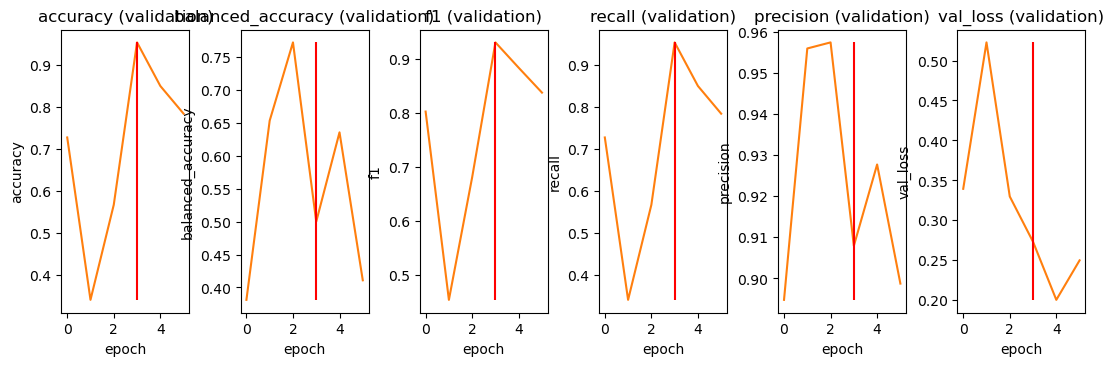

In [41]:
# visualize
# plot training curve
plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.7,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

# mark best performing epoch
best_model_epoch = np.argmax(history_val['f1'])

metrics = history_val.keys()
for i, metric in enumerate(metrics):
    plt.subplot(1, 6, i + 1)
    plt.plot(history_val[metric], color='C1')
    plt.vlines(x=best_model_epoch, ymin=min(history_val[metric]), ymax=max(history_val[metric]), color='red')
    plt.title(f'{metric} (validation)')
    plt.ylabel(metric)
    plt.xlabel('epoch')

plt.show()

Check number of epochs by stratified group 5-fold CV

In [25]:
scores_epochs = dict()

In [26]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    for epochs in (10, 20):
        model = CNN(path, variable=0, epochs=epochs, learning_rate=1e-3, batch_size=16)

        scores_epochs[epochs] = stratified_group_k_fold(path=path,
                                                                      groups=subjects,
                                                                      model=model,
                                                                      folds=5,
                                                                      images=True,
                                                                      verbose=True,
                                                                      variable=0)

Starting stratified group 5-fold for physical fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10
16/16 [==============================] - 37s 739ms/step - loss: 0.7069
Epoch 2/10
16/16 [==============================] - 12s 709ms/step - loss: 0.5756
Epoch 3/10
16/16 [==============================] - 11s 687ms/step - loss: 0.4634
Epoch 4/10
16/16 [==============================] - 11s 688ms/step - loss: 0.4907
Epoch 5/10
16/16 [==============================] - 12s 696ms/step - loss: 0.4762
Epoch 6/10
16/16 [==============================] - 12s 695ms/step - loss: 0.3419
Epoch 7/10
16/16 [==============================] - 12s 696ms/step - loss: 0.3653
Epoch 8/10
16/16 [==============================] - 11s 690ms/step - loss: 0.3109
Epoch 9/10
16/16 [==============================] - 11s 693ms/step - loss: 0.2863
Epoch 10/10
16/16 [==============================] - 11s 691ms/step - loss: 0.2898


 Fold 1 F1: 0.7398417576320199:  20%|██        | 1/5 [03:36<14:27, 216.79s/it]

Epoch 1/10
37/37 [==============================] - 52s 680ms/step - loss: 0.4285
Epoch 2/10
37/37 [==============================] - 26s 682ms/step - loss: 0.3697
Epoch 3/10
37/37 [==============================] - 26s 680ms/step - loss: 0.3193
Epoch 4/10
37/37 [==============================] - 26s 681ms/step - loss: 0.2584
Epoch 5/10
37/37 [==============================] - 26s 681ms/step - loss: 0.2599
Epoch 6/10
37/37 [==============================] - 26s 685ms/step - loss: 0.2440
Epoch 7/10
37/37 [==============================] - 26s 692ms/step - loss: 0.2530
Epoch 8/10
37/37 [==============================] - 26s 680ms/step - loss: 0.2090
Epoch 9/10
37/37 [==============================] - 26s 681ms/step - loss: 0.2122
Epoch 10/10
37/37 [==============================] - 26s 682ms/step - loss: 0.2345


 Fold 2 F1: 0.5974025974025974:  40%|████      | 2/5 [08:36<13:17, 265.79s/it]

Epoch 1/10
35/35 [==============================] - 49s 676ms/step - loss: 0.4764
Epoch 2/10
35/35 [==============================] - 24s 676ms/step - loss: 0.3464
Epoch 3/10
35/35 [==============================] - 24s 677ms/step - loss: 0.3518
Epoch 4/10
35/35 [==============================] - 24s 676ms/step - loss: 0.3101
Epoch 5/10
35/35 [==============================] - 24s 677ms/step - loss: 0.2787
Epoch 6/10
35/35 [==============================] - 24s 676ms/step - loss: 0.2731
Epoch 7/10
35/35 [==============================] - 24s 676ms/step - loss: 0.2382
Epoch 8/10
35/35 [==============================] - 24s 676ms/step - loss: 0.2207
Epoch 9/10
35/35 [==============================] - 24s 676ms/step - loss: 0.2320
Epoch 10/10
35/35 [==============================] - 24s 676ms/step - loss: 0.2093


 Fold 3 F1: 0.8761158062654854:  60%|██████    | 3/5 [13:22<09:09, 274.74s/it]

Epoch 1/10
31/31 [==============================] - 47s 693ms/step - loss: 0.4333
Epoch 2/10
31/31 [==============================] - 22s 693ms/step - loss: 0.3861
Epoch 3/10
31/31 [==============================] - 22s 692ms/step - loss: 0.3130
Epoch 4/10
31/31 [==============================] - 22s 694ms/step - loss: 0.2640
Epoch 5/10
31/31 [==============================] - 22s 692ms/step - loss: 0.2486
Epoch 6/10
31/31 [==============================] - 22s 694ms/step - loss: 0.2308
Epoch 7/10
31/31 [==============================] - 22s 693ms/step - loss: 0.2172
Epoch 8/10
31/31 [==============================] - 22s 694ms/step - loss: 0.2260
Epoch 9/10
31/31 [==============================] - 21s 665ms/step - loss: 0.1915
Epoch 10/10
31/31 [==============================] - 23s 718ms/step - loss: 0.2154


 Fold 4 F1: 0.4111409790707982:  80%|████████  | 4/5 [17:58<04:35, 275.13s/it]

Epoch 1/10
32/32 [==============================] - 46s 687ms/step - loss: 0.5753
Epoch 2/10
32/32 [==============================] - 22s 687ms/step - loss: 0.3472
Epoch 3/10
32/32 [==============================] - 22s 686ms/step - loss: 0.3118
Epoch 4/10
32/32 [==============================] - 22s 689ms/step - loss: 0.2928
Epoch 5/10
32/32 [==============================] - 22s 688ms/step - loss: 0.2730
Epoch 6/10
32/32 [==============================] - 22s 688ms/step - loss: 0.2705
Epoch 7/10
32/32 [==============================] - 22s 688ms/step - loss: 0.2515
Epoch 8/10
32/32 [==============================] - 22s 687ms/step - loss: 0.2298
Epoch 9/10
32/32 [==============================] - 22s 688ms/step - loss: 0.2229
Epoch 10/10
32/32 [==============================] - 22s 688ms/step - loss: 0.2152


 Fold 5 F1: 0.6417224880382776: 100%|██████████| 5/5 [22:34<00:00, 270.93s/it]

Performance model:
 accuracy: 0.664 +- 0.142 

 balanced_accuracy: 0.677 +- 0.097 

 f1: 0.653 +- 0.154 

 recall: 0.664 +- 0.142 

 precision: 0.766 +- 0.098 



Starting stratified group 5-fold for physical fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
16/16 [==============================] - 36s 696ms/step - loss: 0.5718
Epoch 2/20
16/16 [==============================] - 12s 696ms/step - loss: 0.4430
Epoch 3/20
16/16 [==============================] - 11s 696ms/step - loss: 0.3860
Epoch 4/20
16/16 [==============================] - 11s 693ms/step - loss: 0.3625
Epoch 5/20
16/16 [==============================] - 11s 696ms/step - loss: 0.3364
Epoch 6/20
16/16 [==============================] - 11s 695ms/step - loss: 0.3309
Epoch 7/20
16/16 [==============================] - 12s 695ms/step - loss: 0.3001
Epoch 8/20
16/16 [==============================] - 11s 695ms/step - loss: 0.3208
Epoch 9/20
16/16 [==============================] - 11s 696ms/step - loss: 0.3366
Epoch 10/20
16/16 [==============================] - 11s 696ms/step - loss: 0.2836
Epoch 11/20
16/16 [==============================] - 11s 695ms/step - loss: 0.2734
Epoch 12/20
16/16 [==============================] - 11s 694ms/step - loss: 0.2383
Epoch 13/20
1

 Fold 1 F1: 0.8180428136244944:  20%|██        | 1/5 [05:18<21:12, 318.02s/it]

Epoch 1/20
37/37 [==============================] - 48s 666ms/step - loss: 0.4658
Epoch 2/20
37/37 [==============================] - 24s 636ms/step - loss: 0.3354
Epoch 3/20
37/37 [==============================] - 24s 637ms/step - loss: 0.3313
Epoch 4/20
37/37 [==============================] - 27s 711ms/step - loss: 0.3346
Epoch 5/20
37/37 [==============================] - 26s 682ms/step - loss: 0.2693
Epoch 6/20
37/37 [==============================] - 26s 683ms/step - loss: 0.2615
Epoch 7/20
37/37 [==============================] - 26s 683ms/step - loss: 0.2718
Epoch 8/20
37/37 [==============================] - 26s 682ms/step - loss: 0.2055
Epoch 9/20
37/37 [==============================] - 26s 694ms/step - loss: 0.2161
Epoch 10/20
37/37 [==============================] - 27s 711ms/step - loss: 0.1973
Epoch 11/20
37/37 [==============================] - 27s 712ms/step - loss: 0.1861
Epoch 12/20
37/37 [==============================] - 27s 712ms/step - loss: 0.1874
Epoch 13/20
3

 Fold 2 F1: 0.9090909090909091:  40%|████      | 2/5 [14:35<22:56, 458.99s/it]

Epoch 1/20
35/35 [==============================] - 51s 698ms/step - loss: 0.4712
Epoch 2/20
35/35 [==============================] - 25s 704ms/step - loss: 0.3571
Epoch 3/20
35/35 [==============================] - 24s 682ms/step - loss: 0.3703
Epoch 4/20
35/35 [==============================] - 25s 697ms/step - loss: 0.3123
Epoch 5/20
35/35 [==============================] - 25s 691ms/step - loss: 0.2794
Epoch 6/20
35/35 [==============================] - 25s 692ms/step - loss: 0.2662
Epoch 7/20
35/35 [==============================] - 25s 690ms/step - loss: 0.2260
Epoch 8/20
35/35 [==============================] - 25s 691ms/step - loss: 0.2258
Epoch 9/20
35/35 [==============================] - 24s 686ms/step - loss: 0.2405
Epoch 10/20
35/35 [==============================] - 25s 698ms/step - loss: 0.2260
Epoch 11/20
35/35 [==============================] - 24s 686ms/step - loss: 0.2300
Epoch 12/20
35/35 [==============================] - 25s 692ms/step - loss: 0.1758
Epoch 13/20
3

 Fold 3 F1: 0.7708683473389355:  60%|██████    | 3/5 [23:33<16:30, 495.15s/it]

Epoch 1/20
31/31 [==============================] - 49s 729ms/step - loss: 0.3895
Epoch 2/20
31/31 [==============================] - 22s 686ms/step - loss: 0.2965
Epoch 3/20
31/31 [==============================] - 22s 685ms/step - loss: 0.2647
Epoch 4/20
31/31 [==============================] - 22s 685ms/step - loss: 0.2408
Epoch 5/20
31/31 [==============================] - 22s 684ms/step - loss: 0.2757
Epoch 6/20
31/31 [==============================] - 22s 684ms/step - loss: 0.3263
Epoch 7/20
31/31 [==============================] - 22s 685ms/step - loss: 0.1990
Epoch 8/20
31/31 [==============================] - 22s 685ms/step - loss: 0.1856
Epoch 9/20
31/31 [==============================] - 22s 685ms/step - loss: 0.1916
Epoch 10/20
31/31 [==============================] - 22s 685ms/step - loss: 0.1663
Epoch 11/20
31/31 [==============================] - 22s 684ms/step - loss: 0.1560
Epoch 12/20
31/31 [==============================] - 22s 686ms/step - loss: 0.1431
Epoch 13/20
3

 Fold 4 F1: 0.7373181074648618:  80%|████████  | 4/5 [31:48<08:14, 494.92s/it]

Epoch 1/20
32/32 [==============================] - 48s 694ms/step - loss: 0.4797
Epoch 2/20
32/32 [==============================] - 22s 689ms/step - loss: 0.3520
Epoch 3/20
32/32 [==============================] - 23s 703ms/step - loss: 0.3186
Epoch 4/20
32/32 [==============================] - 23s 697ms/step - loss: 0.2745
Epoch 5/20
32/32 [==============================] - 23s 698ms/step - loss: 0.2898
Epoch 6/20
32/32 [==============================] - 22s 689ms/step - loss: 0.2562
Epoch 7/20
32/32 [==============================] - 23s 697ms/step - loss: 0.2397
Epoch 8/20
32/32 [==============================] - 23s 705ms/step - loss: 0.2671
Epoch 9/20
32/32 [==============================] - 23s 715ms/step - loss: 0.2674
Epoch 10/20
32/32 [==============================] - 23s 717ms/step - loss: 0.2281
Epoch 11/20
32/32 [==============================] - 23s 697ms/step - loss: 0.2226
Epoch 12/20
32/32 [==============================] - 23s 701ms/step - loss: 0.1740
Epoch 13/20
3

 Fold 5 F1: 0.7965256277949776: 100%|██████████| 5/5 [40:21<00:00, 484.29s/it]

Performance model:
 accuracy: 0.806 +- 0.058 

 balanced_accuracy: 0.778 +- 0.079 

 f1: 0.806 +- 0.058 

 recall: 0.806 +- 0.058 

 precision: 0.825 +- 0.059 



In [27]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    for epochs in (15, 25):
        model = CNN(path, variable=0, epochs=epochs, learning_rate=1e-3, batch_size=16)

        scores_epochs[epochs] = stratified_group_k_fold(path=path,
                                                        groups=subjects,
                                                        model=model,
                                                        folds=5,
                                                        images=True,
                                                        verbose=True,
                                                        variable=0)

Starting stratified group 5-fold for physical fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/15
16/16 [==============================] - 38s 685ms/step - loss: 0.6632
Epoch 2/15
16/16 [==============================] - 12s 697ms/step - loss: 0.5100
Epoch 3/15
16/16 [==============================] - 11s 693ms/step - loss: 0.4810
Epoch 4/15
16/16 [==============================] - 11s 688ms/step - loss: 0.3787
Epoch 5/15
16/16 [==============================] - 11s 681ms/step - loss: 0.3489
Epoch 6/15
16/16 [==============================] - 12s 701ms/step - loss: 0.3253
Epoch 7/15
16/16 [==============================] - 11s 689ms/step - loss: 0.3296
Epoch 8/15
16/16 [==============================] - 11s 685ms/step - loss: 0.3046
Epoch 9/15
16/16 [==============================] - 11s 690ms/step - loss: 0.2965
Epoch 10/15
16/16 [==============================] - 11s 692ms/step - loss: 0.2785
Epoch 11/15
16/16 [==============================] - 11s 682ms/step - loss: 0.3722
Epoch 12/15
16/16 [==============================] - 11s 691ms/step - loss: 0.3036
Epoch 13/15
1

 Fold 1 F1: 0.7594455841715705:  20%|██        | 1/5 [04:30<18:02, 270.73s/it]

Epoch 1/15
37/37 [==============================] - 56s 694ms/step - loss: 0.4343
Epoch 2/15
37/37 [==============================] - 26s 691ms/step - loss: 0.3220
Epoch 3/15
37/37 [==============================] - 26s 684ms/step - loss: 0.2983
Epoch 4/15
37/37 [==============================] - 26s 689ms/step - loss: 0.2838
Epoch 5/15
37/37 [==============================] - 26s 695ms/step - loss: 0.2654
Epoch 6/15
37/37 [==============================] - 26s 692ms/step - loss: 0.2442
Epoch 7/15
37/37 [==============================] - 26s 694ms/step - loss: 0.2248
Epoch 8/15
37/37 [==============================] - 26s 693ms/step - loss: 0.2295
Epoch 9/15
37/37 [==============================] - 26s 694ms/step - loss: 0.2333
Epoch 10/15
37/37 [==============================] - 27s 717ms/step - loss: 0.1958
Epoch 11/15
37/37 [==============================] - 27s 715ms/step - loss: 0.1783
Epoch 12/15
37/37 [==============================] - 26s 701ms/step - loss: 0.1689
Epoch 13/15
3

 Fold 2 F1: 0.9075369075369075:  40%|████      | 2/5 [11:54<18:36, 372.27s/it]

Epoch 1/15
35/35 [==============================] - 53s 714ms/step - loss: 0.4636
Epoch 2/15
35/35 [==============================] - 25s 695ms/step - loss: 0.3594
Epoch 3/15
35/35 [==============================] - 24s 686ms/step - loss: 0.3984
Epoch 4/15
35/35 [==============================] - 24s 685ms/step - loss: 0.2949
Epoch 5/15
35/35 [==============================] - 24s 686ms/step - loss: 0.2802
Epoch 6/15
35/35 [==============================] - 24s 685ms/step - loss: 0.2603
Epoch 7/15
35/35 [==============================] - 24s 686ms/step - loss: 0.2378
Epoch 8/15
35/35 [==============================] - 24s 685ms/step - loss: 0.2284
Epoch 9/15
35/35 [==============================] - 24s 685ms/step - loss: 0.2759
Epoch 10/15
35/35 [==============================] - 24s 686ms/step - loss: 0.2008
Epoch 11/15
35/35 [==============================] - 24s 685ms/step - loss: 0.1930
Epoch 12/15
35/35 [==============================] - 24s 686ms/step - loss: 0.1944
Epoch 13/15
3

 Fold 3 F1: 0.8163919413919413:  60%|██████    | 3/5 [18:52<13:06, 393.15s/it]

Epoch 1/15
31/31 [==============================] - 48s 676ms/step - loss: 0.4767
Epoch 2/15
31/31 [==============================] - 21s 676ms/step - loss: 0.3268
Epoch 3/15
31/31 [==============================] - 22s 684ms/step - loss: 0.2748
Epoch 4/15
31/31 [==============================] - 21s 675ms/step - loss: 0.2502
Epoch 5/15
31/31 [==============================] - 21s 677ms/step - loss: 0.2384
Epoch 6/15
31/31 [==============================] - 21s 677ms/step - loss: 0.2265
Epoch 7/15
31/31 [==============================] - 21s 676ms/step - loss: 0.2302
Epoch 8/15
31/31 [==============================] - 21s 677ms/step - loss: 0.2191
Epoch 9/15
31/31 [==============================] - 21s 676ms/step - loss: 0.1954
Epoch 10/15
31/31 [==============================] - 21s 676ms/step - loss: 0.1744
Epoch 11/15
31/31 [==============================] - 21s 677ms/step - loss: 0.1689
Epoch 12/15
31/31 [==============================] - 21s 680ms/step - loss: 0.1419
Epoch 13/15
3

 Fold 4 F1: 0.6303384724437355:  80%|████████  | 4/5 [25:12<06:28, 388.21s/it]

Epoch 1/15
32/32 [==============================] - 49s 682ms/step - loss: 0.6121
Epoch 2/15
32/32 [==============================] - 22s 684ms/step - loss: 0.4501
Epoch 3/15
32/32 [==============================] - 22s 683ms/step - loss: 0.3726
Epoch 4/15
32/32 [==============================] - 22s 682ms/step - loss: 0.2924
Epoch 5/15
32/32 [==============================] - 22s 683ms/step - loss: 0.2923
Epoch 6/15
32/32 [==============================] - 22s 683ms/step - loss: 0.3286
Epoch 7/15
32/32 [==============================] - 22s 683ms/step - loss: 0.2853
Epoch 8/15
32/32 [==============================] - 22s 683ms/step - loss: 0.2290
Epoch 9/15
32/32 [==============================] - 23s 696ms/step - loss: 0.2120
Epoch 10/15
32/32 [==============================] - 22s 686ms/step - loss: 0.2184
Epoch 11/15
32/32 [==============================] - 23s 692ms/step - loss: 0.2164
Epoch 12/15
32/32 [==============================] - 23s 703ms/step - loss: 0.2178
Epoch 13/15
3

 Fold 5 F1: 0.4649278475692336: 100%|██████████| 5/5 [31:46<00:00, 381.38s/it]

Performance model:
 accuracy: 0.712 +- 0.151 

 balanced_accuracy: 0.744 +- 0.107 

 f1: 0.716 +- 0.154 

 recall: 0.712 +- 0.151 

 precision: 0.811 +- 0.086 



Starting stratified group 5-fold for physical fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/25
16/16 [==============================] - 40s 697ms/step - loss: 0.7735
Epoch 2/25
16/16 [==============================] - 12s 703ms/step - loss: 0.5825
Epoch 3/25
16/16 [==============================] - 12s 698ms/step - loss: 0.4200
Epoch 4/25
16/16 [==============================] - 12s 711ms/step - loss: 0.3915
Epoch 5/25
16/16 [==============================] - 11s 689ms/step - loss: 0.4390
Epoch 6/25
16/16 [==============================] - 11s 690ms/step - loss: 0.4226
Epoch 7/25
16/16 [==============================] - 11s 691ms/step - loss: 0.3754
Epoch 8/25
16/16 [==============================] - 11s 689ms/step - loss: 0.3398
Epoch 9/25
16/16 [==============================] - 11s 690ms/step - loss: 0.3139
Epoch 10/25
16/16 [==============================] - 11s 689ms/step - loss: 0.3065
Epoch 11/25
16/16 [==============================] - 11s 687ms/step - loss: 0.3505
Epoch 12/25
16/16 [==============================] - 11s 687ms/step - loss: 0.3534
Epoch 13/25
1

 Fold 1 F1: 0.803274864250474:  20%|██        | 1/5 [06:24<25:39, 384.88s/it]

Epoch 1/25
37/37 [==============================] - 51s 681ms/step - loss: 0.4756
Epoch 2/25
37/37 [==============================] - 26s 684ms/step - loss: 0.3498
Epoch 3/25
37/37 [==============================] - 26s 685ms/step - loss: 0.4274
Epoch 4/25
37/37 [==============================] - 26s 686ms/step - loss: 0.3226
Epoch 5/25
37/37 [==============================] - 26s 684ms/step - loss: 0.2641
Epoch 6/25
37/37 [==============================] - 26s 685ms/step - loss: 0.2375
Epoch 7/25
37/37 [==============================] - 26s 683ms/step - loss: 0.2598
Epoch 8/25
37/37 [==============================] - 26s 684ms/step - loss: 0.2295
Epoch 9/25
37/37 [==============================] - 26s 684ms/step - loss: 0.2230
Epoch 10/25
37/37 [==============================] - 26s 685ms/step - loss: 0.2869
Epoch 11/25
37/37 [==============================] - 26s 685ms/step - loss: 0.2491
Epoch 12/25
37/37 [==============================] - 26s 685ms/step - loss: 0.1878
Epoch 13/25
3

 Fold 2 F1: 0.9090909090909091:  40%|████      | 2/5 [17:51<28:07, 562.66s/it]

Epoch 1/25
35/35 [==============================] - 46s 632ms/step - loss: 0.4195
Epoch 2/25
35/35 [==============================] - 23s 632ms/step - loss: 0.3663
Epoch 3/25
35/35 [==============================] - 22s 631ms/step - loss: 0.3944
Epoch 4/25
35/35 [==============================] - 23s 633ms/step - loss: 0.2878
Epoch 5/25
35/35 [==============================] - 22s 632ms/step - loss: 0.2685
Epoch 6/25
35/35 [==============================] - 23s 633ms/step - loss: 0.2627
Epoch 7/25
35/35 [==============================] - 22s 632ms/step - loss: 0.2254
Epoch 8/25
35/35 [==============================] - 22s 632ms/step - loss: 0.2142
Epoch 9/25
35/35 [==============================] - 22s 631ms/step - loss: 0.2089
Epoch 10/25
35/35 [==============================] - 23s 633ms/step - loss: 0.1980
Epoch 11/25
35/35 [==============================] - 23s 632ms/step - loss: 0.1859
Epoch 12/25
35/35 [==============================] - 24s 690ms/step - loss: 0.1936
Epoch 13/25
3

 Fold 3 F1: 0.9064625850340136:  60%|██████    | 3/5 [28:28<19:52, 596.39s/it]

Epoch 1/25
31/31 [==============================] - 51s 685ms/step - loss: 0.5099
Epoch 2/25
31/31 [==============================] - 22s 694ms/step - loss: 0.3309
Epoch 3/25
31/31 [==============================] - 22s 683ms/step - loss: 0.2986
Epoch 4/25
31/31 [==============================] - 21s 681ms/step - loss: 0.3031
Epoch 5/25
31/31 [==============================] - 21s 680ms/step - loss: 0.3170
Epoch 6/25
31/31 [==============================] - 21s 678ms/step - loss: 0.2193
Epoch 7/25
31/31 [==============================] - 21s 680ms/step - loss: 0.2044
Epoch 8/25
31/31 [==============================] - 21s 679ms/step - loss: 0.2087
Epoch 9/25
31/31 [==============================] - 21s 679ms/step - loss: 0.1868
Epoch 10/25
31/31 [==============================] - 21s 679ms/step - loss: 0.2526
Epoch 11/25
31/31 [==============================] - 21s 679ms/step - loss: 0.2063
Epoch 12/25
31/31 [==============================] - 21s 678ms/step - loss: 0.1938
Epoch 13/25
3

 Fold 4 F1: 0.7270017993702204:  80%|████████  | 4/5 [38:27<09:57, 597.53s/it]

Epoch 1/25
32/32 [==============================] - 48s 686ms/step - loss: 0.5054
Epoch 2/25
32/32 [==============================] - 22s 686ms/step - loss: 0.3719
Epoch 3/25
32/32 [==============================] - 22s 685ms/step - loss: 0.3052
Epoch 4/25
32/32 [==============================] - 22s 687ms/step - loss: 0.3055
Epoch 5/25
32/32 [==============================] - 22s 686ms/step - loss: 0.2895
Epoch 6/25
32/32 [==============================] - 22s 686ms/step - loss: 0.2693
Epoch 7/25
32/32 [==============================] - 22s 687ms/step - loss: 0.2425
Epoch 8/25
32/32 [==============================] - 21s 634ms/step - loss: 0.2382
Epoch 9/25
32/32 [==============================] - 21s 634ms/step - loss: 0.2165
Epoch 10/25
32/32 [==============================] - 21s 635ms/step - loss: 0.2060
Epoch 11/25
32/32 [==============================] - 21s 634ms/step - loss: 0.1877
Epoch 12/25
32/32 [==============================] - 21s 636ms/step - loss: 0.1782
Epoch 13/25
3

 Fold 5 F1: 0.7712442396313365: 100%|██████████| 5/5 [48:33<00:00, 582.67s/it]

Performance model:
 accuracy: 0.834 +- 0.066 

 balanced_accuracy: 0.767 +- 0.121 

 f1: 0.823 +- 0.073 

 recall: 0.834 +- 0.066 

 precision: 0.831 +- 0.075 



In [29]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    for epochs in (30,):
        model = CNN(path, variable=0, epochs=epochs, learning_rate=1e-3, batch_size=16)

        scores_epochs[epochs] = stratified_group_k_fold(path=path,
                                                        groups=subjects,
                                                        model=model,
                                                        folds=5,
                                                        images=True,
                                                        verbose=True,
                                                        variable=0)

Starting stratified group 5-fold for physical fatigue


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/30
16/16 [==============================] - 38s 737ms/step - loss: 0.5396
Epoch 2/30
16/16 [==============================] - 12s 733ms/step - loss: 0.4179
Epoch 3/30
16/16 [==============================] - 12s 740ms/step - loss: 0.3861
Epoch 4/30
16/16 [==============================] - 12s 736ms/step - loss: 0.3834
Epoch 5/30
16/16 [==============================] - 12s 733ms/step - loss: 0.3781
Epoch 6/30
16/16 [==============================] - 12s 735ms/step - loss: 0.3352
Epoch 7/30
16/16 [==============================] - 12s 735ms/step - loss: 0.3312
Epoch 8/30
16/16 [==============================] - 12s 735ms/step - loss: 0.3269
Epoch 9/30
16/16 [==============================] - 12s 734ms/step - loss: 0.3170
Epoch 10/30
16/16 [==============================] - 12s 734ms/step - loss: 0.2931
Epoch 11/30
16/16 [==============================] - 12s 735ms/step - loss: 0.2723
Epoch 12/30
16/16 [==============================] - 12s 733ms/step - loss: 0.2360
Epoch 13/30
1

 Fold 1 F1: 0.816074416027668:  20%|██        | 1/5 [07:42<30:48, 462.16s/it]

Epoch 1/30
37/37 [==============================] - 53s 724ms/step - loss: 0.4207
Epoch 2/30
37/37 [==============================] - 27s 725ms/step - loss: 0.3378
Epoch 3/30
37/37 [==============================] - 27s 725ms/step - loss: 0.3773
Epoch 4/30
37/37 [==============================] - 27s 722ms/step - loss: 0.3623
Epoch 5/30
37/37 [==============================] - 24s 633ms/step - loss: 0.2934
Epoch 6/30
37/37 [==============================] - 24s 633ms/step - loss: 0.2297
Epoch 7/30
37/37 [==============================] - 24s 633ms/step - loss: 0.2270
Epoch 8/30
37/37 [==============================] - 24s 634ms/step - loss: 0.2160
Epoch 9/30
37/37 [==============================] - 24s 633ms/step - loss: 0.2131
Epoch 10/30
37/37 [==============================] - 24s 632ms/step - loss: 0.2031
Epoch 11/30
37/37 [==============================] - 24s 632ms/step - loss: 0.1731
Epoch 12/30
37/37 [==============================] - 24s 633ms/step - loss: 0.1895
Epoch 13/30
3

 Fold 2 F1: 0.8084415584415584:  40%|████      | 2/5 [20:33<32:11, 643.86s/it]

Epoch 1/30
35/35 [==============================] - 45s 634ms/step - loss: 0.4480
Epoch 2/30
35/35 [==============================] - 23s 634ms/step - loss: 0.3391
Epoch 3/30
35/35 [==============================] - 23s 634ms/step - loss: 0.3147
Epoch 4/30
35/35 [==============================] - 23s 635ms/step - loss: 0.2947
Epoch 5/30
35/35 [==============================] - 23s 636ms/step - loss: 0.2848
Epoch 6/30
35/35 [==============================] - 23s 635ms/step - loss: 0.2512
Epoch 7/30
35/35 [==============================] - 23s 634ms/step - loss: 0.2723
Epoch 8/30
35/35 [==============================] - 23s 634ms/step - loss: 0.2476
Epoch 9/30
35/35 [==============================] - 23s 634ms/step - loss: 0.2025
Epoch 10/30
35/35 [==============================] - 23s 635ms/step - loss: 0.1998
Epoch 11/30
35/35 [==============================] - 23s 635ms/step - loss: 0.1918
Epoch 12/30
35/35 [==============================] - 23s 635ms/step - loss: 0.2286
Epoch 13/30
3

 Fold 3 F1: 0.8795803066989507:  60%|██████    | 3/5 [32:35<22:39, 679.59s/it]

Epoch 1/30
31/31 [==============================] - 43s 633ms/step - loss: 0.5261
Epoch 2/30
31/31 [==============================] - 20s 634ms/step - loss: 0.3506
Epoch 3/30
31/31 [==============================] - 20s 633ms/step - loss: 0.2969
Epoch 4/30
31/31 [==============================] - 20s 633ms/step - loss: 0.3353
Epoch 5/30
31/31 [==============================] - 20s 633ms/step - loss: 0.2515
Epoch 6/30
31/31 [==============================] - 20s 634ms/step - loss: 0.2315
Epoch 7/30
31/31 [==============================] - 20s 635ms/step - loss: 0.2285
Epoch 8/30
31/31 [==============================] - 20s 635ms/step - loss: 0.1984
Epoch 9/30
31/31 [==============================] - 20s 634ms/step - loss: 0.1878
Epoch 10/30
31/31 [==============================] - 20s 634ms/step - loss: 0.1756
Epoch 11/30
31/31 [==============================] - 20s 634ms/step - loss: 0.1639
Epoch 12/30
31/31 [==============================] - 20s 635ms/step - loss: 0.1644
Epoch 13/30
3

 Fold 4 F1: 0.7531079875161124:  80%|████████  | 4/5 [43:28<11:09, 669.35s/it]

Epoch 1/30
32/32 [==============================] - 44s 641ms/step - loss: 0.4727
Epoch 2/30
32/32 [==============================] - 21s 640ms/step - loss: 0.3422
Epoch 3/30
32/32 [==============================] - 21s 639ms/step - loss: 0.3190
Epoch 4/30
32/32 [==============================] - 21s 641ms/step - loss: 0.2843
Epoch 5/30
32/32 [==============================] - 21s 641ms/step - loss: 0.2720
Epoch 6/30
32/32 [==============================] - 21s 640ms/step - loss: 0.2778
Epoch 7/30
32/32 [==============================] - 21s 640ms/step - loss: 0.2340
Epoch 8/30
32/32 [==============================] - 21s 641ms/step - loss: 0.2247
Epoch 9/30
32/32 [==============================] - 21s 640ms/step - loss: 0.2001
Epoch 10/30
32/32 [==============================] - 21s 639ms/step - loss: 0.1996
Epoch 11/30
32/32 [==============================] - 21s 640ms/step - loss: 0.1816
Epoch 12/30
32/32 [==============================] - 21s 640ms/step - loss: 0.1754
Epoch 13/30
3

 Fold 5 F1: 0.7819025891341255: 100%|██████████| 5/5 [54:54<00:00, 658.85s/it]

Performance model:
 accuracy: 0.809 +- 0.043 

 balanced_accuracy: 0.778 +- 0.048 

 f1: 0.808 +- 0.042 

 recall: 0.809 +- 0.043 

 precision: 0.83 +- 0.042 



In [30]:
# stratified group 5-fold
with open('scores_epcohs.txt', 'w') as dat:
    dat.write(str(scores_epochs))

10    0.653245
20    0.806369
15    0.715728
25    0.823415
30    0.807821
dtype: float64

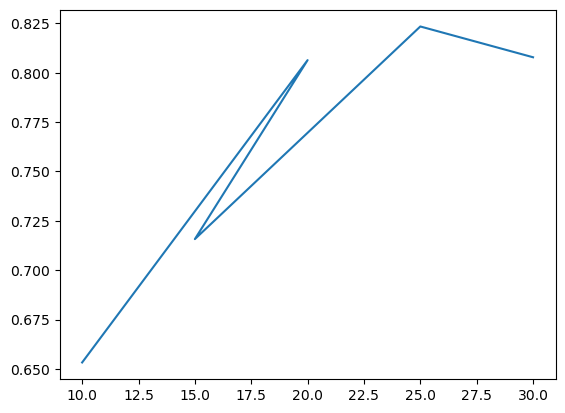

In [52]:
t = pd.DataFrame([{key: element['f1']} for key, value in scores_epochs.items() for element in value])
plt.plot(t.mean())
t.mean()

PCA, t-SNE embeddings

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [42]:
# load fatigue labels
y_true = np.empty(N, dtype=int)
for i in range(N):
    y_true[i] = np.load(path + f'/labels{i}.npy', allow_pickle=True)[0]

Physical fatigue
Expained variance - 2 components - (cummulative): 0.5802491727417157
Expained variance - 50 components - (cummulative): 0.8815208280424442


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


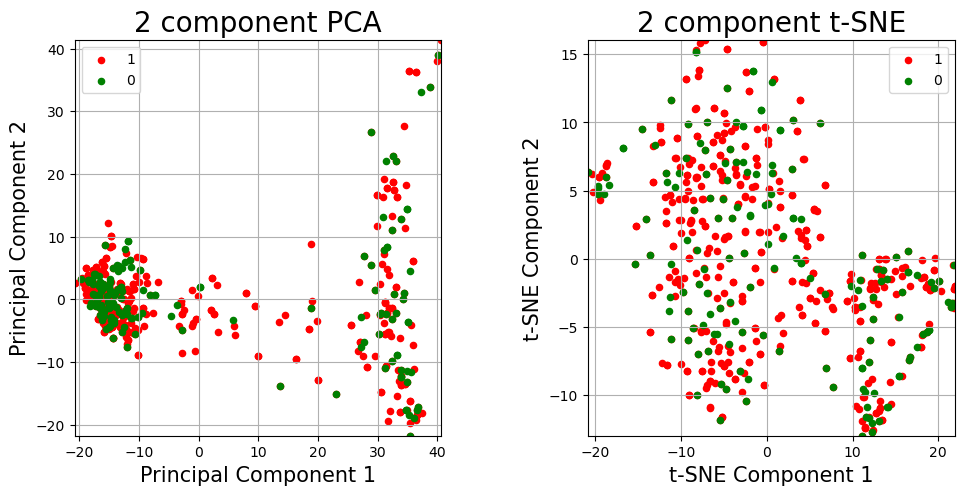

Mental fatigue
Expained variance - 2 components - (cummulative): 0.5802491727417158
Expained variance - 50 components - (cummulative): 0.8815188549290871


C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jjung\anaconda3\envs\tf-sklearn-keras\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


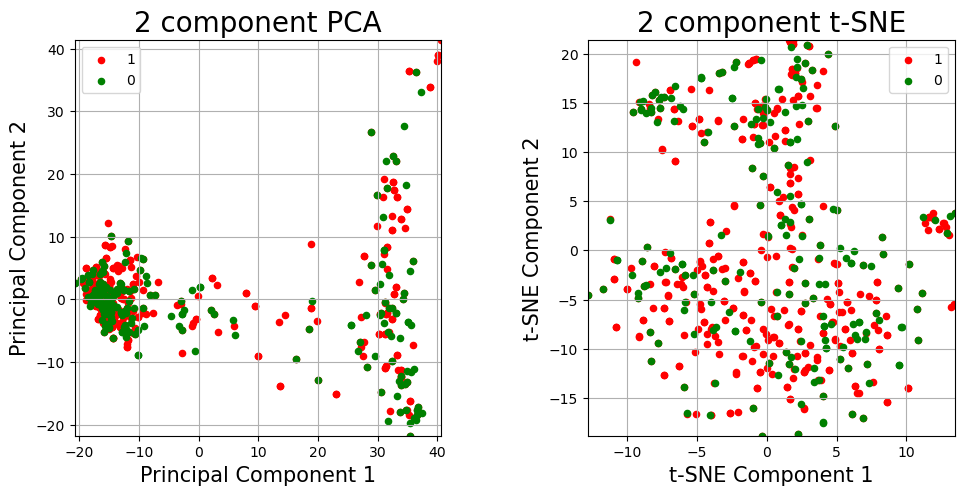

In [67]:
for variable in (0, 1):
    print(('Physical fatigue', 'Mental fatigue')[variable])

    model = CNN(path, variable=variable, epochs=1, learning_rate=1e-3, batch_size=16)

    # load fatigue labels
    y_true = np.empty(N, dtype=int)
    for i in range(N):
        y_true[i] = np.load(path + f'/labels{i}.npy', allow_pickle=True)[variable]

    # get embeddings from CNN
    embeddings = np.empty((N, 12800), dtype=float)
    for i, (x,y) in enumerate(DataGenerator(path, np.arange(N), batch_size=1, variable=variable)):
        z = [model.model.mobilenet(x[..., i:i+3], training=False) for i in range(0, CHANNELS, 3)]

        # Concatenation
        z = model.model.concat(z)

        # Global pooling
        z = model.model.pool(z)

        embeddings[i, ] = z

    # PCA
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)
    print(f'Expained variance - 2 components - (cummulative): {np.sum(pca.explained_variance_ratio_)}')

    # visualize
    principalDf = pd.DataFrame(data=pca_embeddings, columns=['principal component 1', 'principal component 2'])

    # concat labels
    labels = pd.DataFrame(data=y_true, columns=['target'])
    finalDf = pd.concat([principalDf, labels[['target']]], axis = 1)

    # plot
    fig = plt.figure(figsize = (8,4))
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.0,
                        wspace=0.4,
                        hspace=0.4)
    ax = fig.add_subplot(1,2,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [1, 0]
    colors = ['r', 'g']
    for target, color in zip(targets, colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                   finalDf.loc[indicesToKeep, 'principal component 2'],
                   c=color,
                   s=20)

    x_min, x_max = np.min(principalDf.to_numpy()[:, 0]), np.max(principalDf.to_numpy()[:, 0])
    y_min, y_max = np.min(principalDf.to_numpy()[:, 1]), np.max(principalDf.to_numpy()[:, 1])
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.legend(targets)
    ax.grid()

    # t-SNE
    # we first reduce the dimensions of the embeddings with PCA as recommended
    pca_50 = PCA(n_components=50, random_state=42)
    pca_embeddings_50 = pca_50.fit_transform(embeddings)
    print(f'Expained variance - 50 components - (cummulative): {np.sum(pca_50.explained_variance_ratio_)}')

    # now we apply t-SNE
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=42)
    tsne_embeddings = tsne.fit_transform(pca_embeddings_50)

    # visualize
    tsneDf = pd.DataFrame(data=tsne_embeddings, columns=['t-SNE component 1', 't-SNE component 2'])

    # concat labels
    labels = pd.DataFrame(data=y_true, columns=['target'])
    finalDf_tsne = pd.concat([tsneDf, labels[['target']]], axis = 1)

    # plot
    ax = fig.add_subplot(1,2,2)
    ax.set_xlabel('t-SNE Component 1', fontsize = 15)
    ax.set_ylabel('t-SNE Component 2', fontsize = 15)
    ax.set_title('2 component t-SNE', fontsize = 20)
    targets = [1, 0]
    colors = ['r', 'g']
    for target, color in zip(targets, colors):
        indicesToKeep = finalDf_tsne['target'] == target
        ax.scatter(finalDf_tsne.loc[indicesToKeep, 't-SNE component 1'],
                   finalDf_tsne.loc[indicesToKeep, 't-SNE component 2'],
                   c=color,
                   s=20)

    x_min, x_max = np.min(tsneDf.to_numpy()[:, 0]), np.max(tsneDf.to_numpy()[:, 0])
    y_min, y_max = np.min(tsneDf.to_numpy()[:, 1]), np.max(tsneDf.to_numpy()[:, 1])
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.legend(targets)
    ax.grid()

    plt.show()

Daily majority vote

In [ ]:
model = CNN(path, variable=0, epochs=10, learning_rate=1e-3, batch_size=16)

N = sum([1 for p in os.listdir(path) if (p[:14] == 'feature_vector' and p[:19] != 'feature_vector_stat')])

# load labels (we need them for stratification)
y = np.empty(N, dtype=int)
for i in range(N):
    y[i] = np.load(path + f'/labels{i}.npy', allow_pickle=True)[variable]  # TODO: multiclass

# CV
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
scores_cv = []
data_indices = np.arange(N)

print(f'Starting stratified group {5}-fold for {["physical fatigue", "mental fatigue"][variable]}')
with tqdm(total=5) as pbar:
    for i, (train_indices, test_indices) in enumerate(cv.split(X=data_indices, y=y, groups=subjects)):
        # test labels
        y_test = y[test_indices]

        # training
        model.reset()
        model.fit(train_indices)

        # predict
        y_pred = model.predict(test_indices)

        # daily majorities
        y_pred_daily = np.array(list(daily_majority_vote(y_pred, test_indices, metadata).values()))
        y_true_daily = np.array(list(daily_majority_vote(y_test, test_indices, metadata).values()))

        # evaluate
        scores = evaluator(y_pred_daily, y_true_daily, verbose=False)
        scores_cv.append(scores)

        # agreements
        print('agreements:', agreements(y_pred, model.test_indices, metadata))

        # for progress bar
        pbar.update(1)
        pbar.set_description(f' Fold {i+1} F1: {scores["f1"]}')

# print (if verbose==True)
print('Performance model:')
metrics = scores_cv[0].keys()
for metric in metrics:
    mean = np.mean([scores_cv_i[metric] for scores_cv_i in scores_cv])
    std = np.std([scores_cv_i[metric] for scores_cv_i in scores_cv])
    print(f' {metric}: {round(mean, 3)} +- {round(std, 3)} \n')

# TODO: check why so few days (even fewer than statistical features)